<a href="https://colab.research.google.com/github/kikiymini/7506R-1C2024-GRUPO02/blob/main/7506R_1C2024_GRUPO02_N1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Organizaci&oacute;n de Datos</center>

<font color='red'>Agregar a la carpeta 7506R-1C2024-GRUPO02 QUE TENGO EN DRIVE el archivo barrio.csv Descargarlo de acá [GCBA](https://data.buenosaires.gob.ar/dataset/barrios/resource/juqdkmgo-191-resource) y subirlo a dicha carpeta</font>

#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1: Propiedades en venta</center>

### <center> Grupo 2</center>

## Integrantes:

*   Aramayo Carolina
*   Utrera Maximo Damian
*   Villalba Ana Daniela
*   Fiorilo Roy


# Importación de librerias

In [128]:
import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt

from shapely import wkt
from shapely.geometry import MultiPolygon, Polygon, Point

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.metrics import silhouette_score

# Lectura de archivo

### Desde google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/7506R-1C2024-GRUPO02/Dataset/properati_argentina_2021.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive


### Desde maquina local

In [ ]:
file_path = './dataset/properati_argentina_2021.csv'
df = pd.read_csv(file_path)

FileNotFoundError: [Errno 2] No such file or directory: './dataset/properati_argentina_2021.csv'

In [ ]:
df.head()

# Análisis Exploratorio y Pre-procesamiento de Datos

En esta sección vamos a filtrar y seleccionar los datos a trabajar a lo largo del proyecto.




#### Filtrado

Se deben filtrar
únicamente los anuncios de propiedades de tipo vivienda ( Casa, PH y Departamento ) ubicados
en Capital Federal cuyo tipo de operación sea venta y su precio se encuentre en dólares (USD).

En la etapa de filtrado, vamos a utilizar la funcionalidad de `str.contains()` de pandas. Este código se basa en la documentación oficial de pandas que puedes encontrar en [este enlace](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.contains.html).


In [3]:
# filtro por tipo de propiedad
# str.contains() se utiliza para buscar patrones de texto dentro de las cadenas en una serie.
# USD: indica el patrón que busco
# case: no distingue entre mayúsculas y minúsculas
# na: no registro valores NaN
filtro = df.property_type.str.contains('Casa|PH|Departamento',case=False,na=False)
ds_propiedades_filtradas = df[filtro]
ds_propiedades_filtradas = ds_propiedades_filtradas[~ds_propiedades_filtradas['property_type'].str.contains('Casa de campo')]

In [4]:
# filtro propiedades en Capital Federal
filtro = ds_propiedades_filtradas.place_l2.str.contains('Capital Federal',case=False,na=False)
ds_propiedades_filtradas = ds_propiedades_filtradas[filtro]

In [5]:
# filtro propiedades en venta
filtro = ds_propiedades_filtradas.operation.str.contains('Venta',case=False,na=False)
ds_propiedades_filtradas = ds_propiedades_filtradas[filtro]

In [6]:
# filtro por moneda DÓLAR
filtro = ds_propiedades_filtradas.property_currency.str.contains('USD',case=False,na=False)
ds_propiedades_filtradas = ds_propiedades_filtradas[filtro]

In [7]:
# DataSet filtrado
ds_propiedades_filtradas.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,2021-09-09,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,171.0,133.0,210000.0,USD,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,NaN,NaN,NaN,Venta,Departamento,3.0,2.0,58.0,55.0,82900.0,USD,VENTA TRES AMBIENTES LA BOCA PISO ALTO
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,NaN,NaN,NaN,Venta,Departamento,4.0,3.0,70.0,70.0,99000.0,USD,Departamento - 4 Ambientes - Catalinas Sur
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,NaN,NaN,NaN,Venta,Departamento,4.0,2.0,NaN,104.0,146000.0,USD,Venta departamento 4 ambientes Once
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,NaN,NaN,NaN,Venta,PH,4.0,2.0,NaN,73.0,250000.0,USD,PH - Boedo


#### Sets de entrenamiento y test

Se debe separar un conjunto de entrenamiento (80%) y un conjunto de test (20%).

En esta sección se utiliza el método `train_test_split()` de Scikit-learn para dividir el conjunto de datos en conjuntos de entrenamiento y prueba. Este método es útil para evaluar el rendimiento de un modelo de aprendizaje automático.

El método `train_test_split()` se puede encontrar en la documentación oficial de Scikit-learn:

- [train_test_split() en Scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html)
- [Documentación de train_test_split() en Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split)


In [8]:
# Dividir el dataset en conjuntos de entrenamiento y prueba
prop_train, prop_test = train_test_split(ds_propiedades_filtradas, train_size=0.8)
print("Propiedades para entrenar:", len(prop_train))
print("Propiedades para testear:", len(prop_test))

Propiedades para entrenar: 75399
Propiedades para testear: 18850


## Exploración Inicial (no terminada)

### Medidas de resumen de las variables cuantitativas del Dataset

In [ ]:
# Creo resumen con describe
ds_propieades_filtradas_resumen = ds_propiedades_filtradas.describe()
# Agrego moda a la tabla resumen
ds_propieades_filtradas_resumen.loc['mode'] = ds_propiedades_filtradas.mode().iloc[0]
ds_propieades_filtradas_resumen


,latitud,longitud,place_l6,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
count,90519.000000,90519.000000,0.0,93205.000000,83262.000000,89405.000000,90895.000000,9.424900e+04
mean,-34.591481,-58.449795,NaN,2.822799,2.014629,109.092970,87.931932,2.262382e+05
std,0.181719,0.292630,NaN,1.426148,1.129767,980.401976,990.927129,3.186035e+05
min,-53.788624,-71.471192,NaN,1.000000,-1.000000,10.000000,1.000000,5.000000e+03
25%,-34.615975,-58.466522,NaN,2.000000,1.000000,45.000000,40.000000,9.500000e+04
50%,-34.595790,-58.439000,NaN,3.000000,2.000000,65.000000,58.000000,1.439000e+05
75%,-34.577413,-58.408862,NaN,4.000000,3.000000,105.000000,88.000000,2.370000e+05
max,-24.219827,-54.133330,NaN,40.000000,70.000000,137000.000000,217000.000000,2.140000e+07
mode,-34.541250,-58.472966,NaN,3.000000,1.000000,50.000000,40.000000,1.100000e+05


En esta tabla resumen se pueden apreciar (en orden):

* El recuento de las entradas validas por atributo.
* El mean de cada atributo.
* La desviacion estandar.
* El valor minimo de cada atributo.
* El percentil 25.
* El percentil 50.
* El percentil 75.
* El valor maximo de cada atributo.
* La moda de cada atributo.

### Cantidad de valores posibles para cada variable cualitativo

In [ ]:
# Mostrar la cantidad de valores posibles para cada variable cualitativa
variables_cualitativas = [
    'property_type',
    'operation',
    'property_currency',
    'start_date',
    'end_date',
    'created_on',
    'place_l2',
    'place_l3',
    'place_l4',
    'place_l5',
    'place_l6',
    ]
ds_propiedades_filtradas[variables_cualitativas].nunique()

property_type          3
operation              1
property_currency      1
start_date           365
end_date             607
created_on           365
place_l2               1
place_l3              57
place_l4               4
place_l5               0
place_l6               0
dtype: int64

### Frecuencia de los valores posibles de variables cualitativas

En un grafico de barras se veran las frecuencias de los valores posibles para los atributos cualitativos mas importantes y donde hay mas de 1 alternativa, es decir no se tomara por ejemplo *place_l2* porque se sabe que por el filtro el 100% de los valores sera 'Capital Federal', asi mismo para *operation* que sera 'Venta' y *property_currency* que sera 'USD'.

* created_on (publicaciones por mes)
* place_l3 (los 15 mas frecuentes)
* place_l4
* property_type

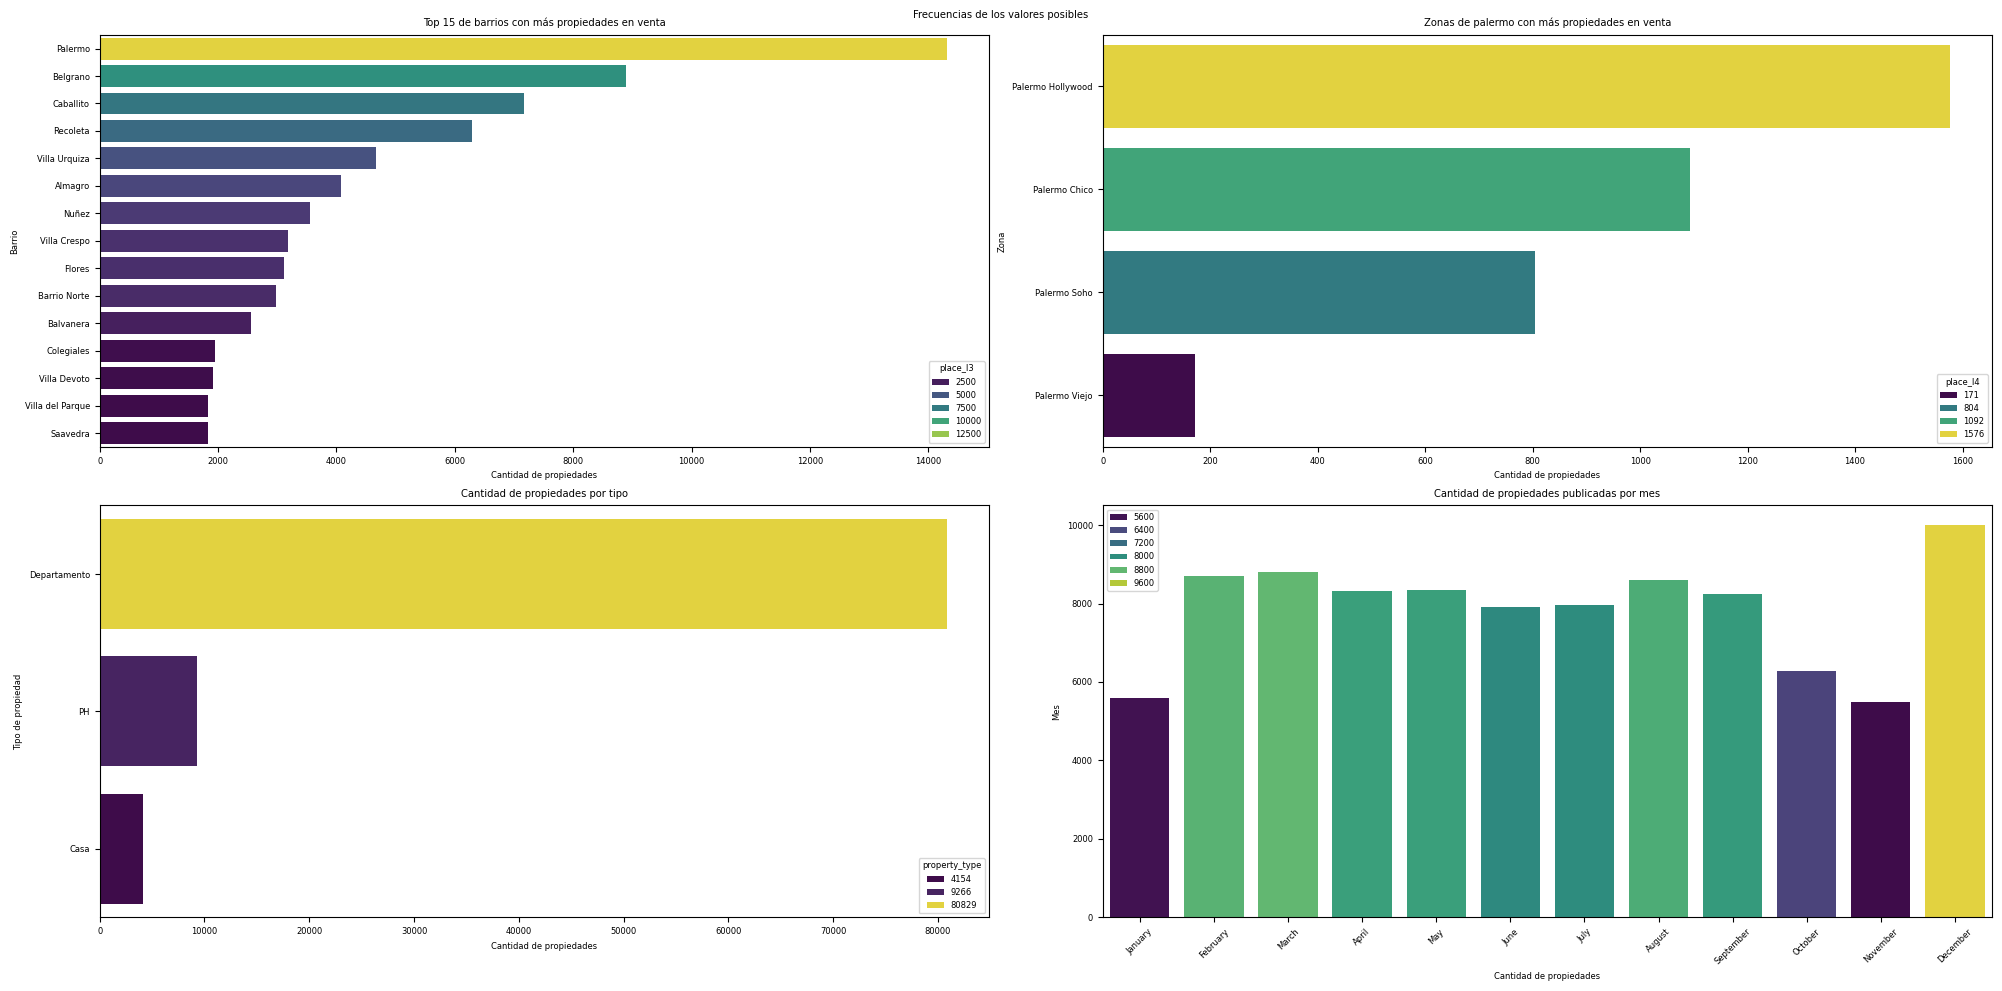

In [ ]:
plt.figure(figsize=(20, 10)) # 10x10 inches
plt.suptitle('Frecuencias de los valores posibles')

# bar plot por place_l3
plt.subplot(2, 2, 1) # 2 filas, 2 columnas, 1 posicion
frecuencias_place_3 = ds_propiedades_filtradas["place_l3"].value_counts().head(15)
sns.barplot(x=frecuencias_place_3.values, y=frecuencias_place_3.index, hue=frecuencias_place_3, palette='viridis')
plt.title('Top 15 de barrios con más propiedades en venta')
plt.xlabel('Cantidad de propiedades')
plt.ylabel('Barrio')

# bar plot por place_l4
plt.subplot(2, 2, 2) # 2 filas, 2 columnas, 2 posicion
frecuencias_place_4 = ds_propiedades_filtradas["place_l4"].value_counts()
sns.barplot(x=frecuencias_place_4.values, y=frecuencias_place_4.index, hue=frecuencias_place_4, palette='viridis')
# Ya que los 4 valores posibles pertenecen a Palermo
plt.title('Zonas de palermo con más propiedades en venta')
plt.xlabel('Cantidad de propiedades')
plt.ylabel('Zona')

# bar plot por property_type
plt.subplot(2, 2, 3) # 2 filas, 2 columnas, 3 posicion
frecuencias_property_type = ds_propiedades_filtradas["property_type"].value_counts()
sns.barplot(x=frecuencias_property_type.values, y=frecuencias_property_type.index, hue=frecuencias_property_type, palette='viridis')
plt.title('Cantidad de propiedades por tipo')
plt.xlabel('Cantidad de propiedades')
plt.ylabel('Tipo de propiedad')

# bar plot por mes de created_on
plt.subplot(2, 2, 4) # 2 filas, 2 columnas, 4 posicion
ds_propiedades_filtradas["created_on"] = pd.to_datetime(ds_propiedades_filtradas["created_on"])
meses = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
frecuencias_mes = ds_propiedades_filtradas["created_on"].dt.month_name().value_counts().reindex(meses)
sns.barplot(x=frecuencias_mes.index, y=frecuencias_mes.values, hue=frecuencias_mes, palette='viridis')
plt.legend(loc='upper left')
plt.title('Cantidad de propiedades publicadas por mes')
plt.xlabel('Cantidad de propiedades')
plt.ylabel('Mes')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Variables irrelevantes para el analisis

Las variables que se pueden considerar irrelevantes para el analisis que se les dara son:

* **ID**: no aporta informacion para analizar, sin embargo puede ser util para propositos de manejo de datos.
* **Place_l5/l6**: no tienen ningun valor en ningun registro lo que los hace innecesarios.
* **Operation**: debido a el pre-procesamiento de los datos todos los registros tendran una operacion de venta, es decir que este atributo pasa a ser redundante.
* **Property_currency**: similarmente como pasa con *operation* pasa con este otro atributo, es un atributo redundante ya que todos seran USD.
* **Property_title**: no aporta informacion relevante al analisis.
* **Latitud/Longitud**: como ya se tiene el barrio de la propiedad en place_l2 esta informacion puede o no ser relevante dependiendo si se quiere ver la ubicacion exacta o si se quiere validar el barrio.
* **Variables de fechas (start/end/created)**: estas variables podrian ser utiles si se hace un analisis por ejemplo para ver cuales son las fechas donde mas ventas empiezan/terminan/se crean, de lo contrario no es relevante.

#### En sintesis

En base a lo anterior dicho se toma la decision de dejar de contar con los atributos:

* place_l5/l6
* operation
* property_currency
* property title

In [ ]:
# Nuevo filtro para eliminar dichas columnas

### Analisis grafico de distribucion de variables mas relevantes

* property_price (los 15 mas frecuentes)

KeyboardInterrupt: 

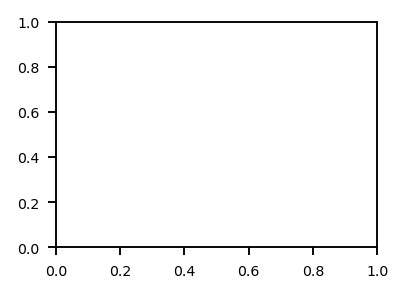

In [ ]:
# plot de distribucion de property_price

plt.figure(figsize=(20, 10), dpi=170)
plt.subplot(5, 7, 1) # 5 filas, 7 columnas, 1 posicion
plt.hist(data=ds_propiedades_filtradas,x="property_price",bins=5000, color="#2348F0",rwidth=0.9)
plt.xlim(25000,500000)
plt.xlabel("Precio en USD")
plt.ylabel("Cantidad de propiedades")
plt.title("Distribución del precio de las propiedades")
plt.xticks(rotation=45)
plt.rc('font', size=6)

plt.show()

In [ ]:
# EPLORACION INICIAL -- TODAVIA NO TERMINADA

## Visualización de los datos

Text(0.5, 1.0, 'Distribución del precio de las propiedades')

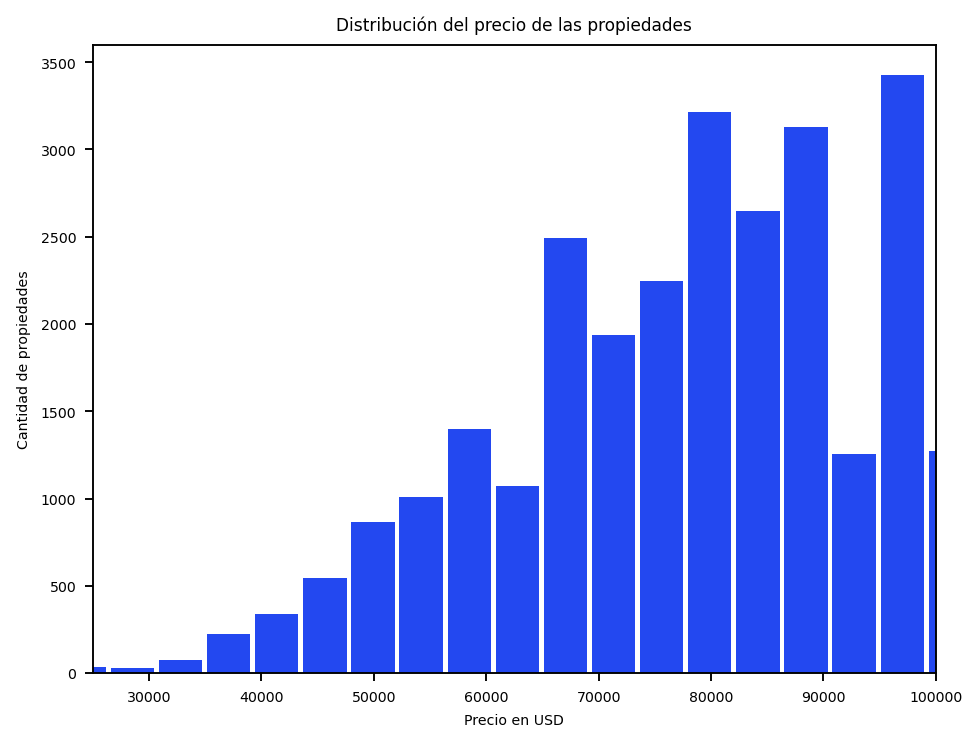

In [ ]:
plt.figure(dpi=170)
plt.hist(data=ds_propiedades_filtradas,x="property_price",bins=5000, color="#2348F0",rwidth=0.9)
plt.xlim(25000,100000)
plt.grid(False)
plt.xlabel("Precio en USD")
plt.ylabel("Cantidad de propiedades")
plt.title("Distribución del precio de las propiedades")
#Histograma basado en el precio, muestra la cantiad de publicaciones segun el precio que tienen

In [ ]:
ds_propiedades_filtradas = ds_propiedades_filtradas[ds_propiedades_filtradas['property_rooms'] < 6]
ds_propiedades_filtradas = ds_propiedades_filtradas[(ds_propiedades_filtradas['property_price'] > 20000) & (ds_propiedades_filtradas['property_price'] < 500000)]
df = ds_propiedades_filtradas.pivot_table(values='property_price', index='place_l3',columns='property_rooms')
df
#Modificamos un rango para que se vea mejor la visualizacion

property_rooms,1.0,2.0,3.0,4.0,5.0
place_l3,,,,,
Abasto,69217.483333,93577.013514,122969.072727,200176.470588,327000.000000
Agronomía,72346.294118,105211.079365,172307.462687,245677.777778,272615.736842
Almagro,76403.287779,97328.448067,140748.842600,204678.698529,271689.314607
Balvanera,66020.146667,77840.329285,118116.539541,156565.957560,206471.296296
Barracas,89309.791908,109176.360000,155940.859564,202959.759259,250813.081967
Barrio Norte,95444.509434,114794.077889,195035.655034,279883.243243,340617.829457
Belgrano,103788.116445,144599.999124,215639.008841,313862.752457,357349.828179
Boca,60988.442308,69070.353982,94057.821429,143409.803922,144500.000000
Boedo,69420.233129,90627.981675,136057.379227,203743.155280,254484.375000


Text(87.31944444444443, 0.5, 'Zonas de Capital Federal')

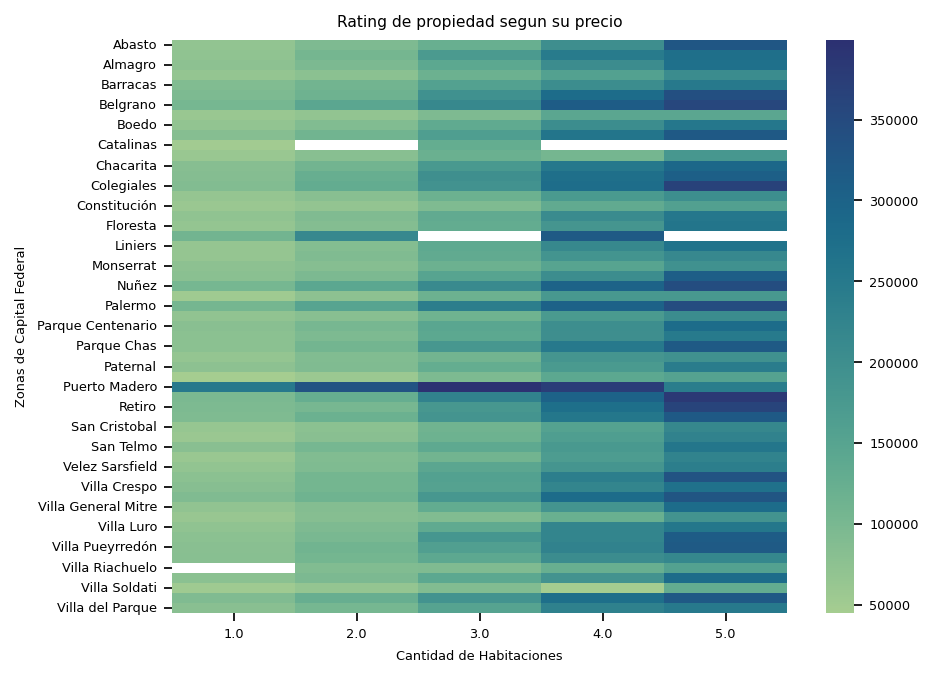

In [ ]:
plt.figure(dpi=155)
plt.title("Rating de propiedad segun su precio")
sns.heatmap(df,square=False, cmap='crest')
plt.xlabel("Cantidad de Habitaciones")
plt.ylabel("Zonas de Capital Federal")
#heapmap que muestra el precio por propiedad tomando en cuenta la cantidad de habitaciones y su ubicacion

## Datos Faltantes
En esta sección se va a realizar el análsis de la presencia de datos faltantes

###Análisis de datos faltantes a nivel columna

Realizar análisis de datos faltantes a nivel de columna. Graficar para cada variable el porcentaje de datos faltantes con respecto al total del dataset.

####Análisis previo

In [9]:
ds_train = prop_train
ds_test = prop_test

In [10]:
ds_train.columns

Index(['id', 'start_date', 'end_date', 'created_on', 'latitud', 'longitud',
       'place_l2', 'place_l3', 'place_l4', 'place_l5', 'place_l6', 'operation',
       'property_type', 'property_rooms', 'property_bedrooms',
       'property_surface_total', 'property_surface_covered', 'property_price',
       'property_currency', 'property_title'],
      dtype='object')

Para iniciar, vamos a analizar la cantidad de datos faltantes por columna y su porcentaje

In [11]:
def obtener_filas(ds):
  return ds.shape[0]

def obtener_columnas(ds):
  return ds.shape[1]

In [12]:
filas = obtener_filas(ds_train)
columnas = obtener_columnas(ds_train)
print("El dataset de entrenamiento tiene {} filas y {} columnas".format(filas,columnas))

El dataset de entrenamiento tiene 75399 filas y 20 columnas


Obtengo el promedio de cada columna que contiene datos nulos

In [13]:
def obtener_promedio_nulos(ds):
  return ds.isna().sum() / obtener_filas(ds) * 100

promedio_datos_nulos = obtener_promedio_nulos(ds_train)
promedio_datos_nulos

id                            0.000000
start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       3.907214
longitud                      3.907214
place_l2                      0.000000
place_l3                      0.449608
place_l4                     96.155121
place_l5                    100.000000
place_l6                    100.000000
operation                     0.000000
property_type                 0.000000
property_rooms                1.091526
property_bedrooms            11.687158
property_surface_total        5.156567
property_surface_covered      3.588907
property_price                0.000000
property_currency             0.000000
property_title                0.000000
dtype: float64

Muestro la cantidad de datos nulos por columna

In [14]:
def obtener_cantidad_nulos_ds(ds):
  return ds.isna().sum()

cant_datos_nulos = obtener_cantidad_nulos_ds(ds_train)
cant_datos_nulos

id                              0
start_date                      0
end_date                        0
created_on                      0
latitud                      2946
longitud                     2946
place_l2                        0
place_l3                      339
place_l4                    72500
place_l5                    75399
place_l6                    75399
operation                       0
property_type                   0
property_rooms                823
property_bedrooms            8812
property_surface_total       3888
property_surface_covered     2706
property_price                  0
property_currency               0
property_title                  0
dtype: int64

Grafico esta relación

<Axes: title={'center': 'Gráfico del promedio de datos nulos por columna'}, xlabel='columna', ylabel='promedio'>

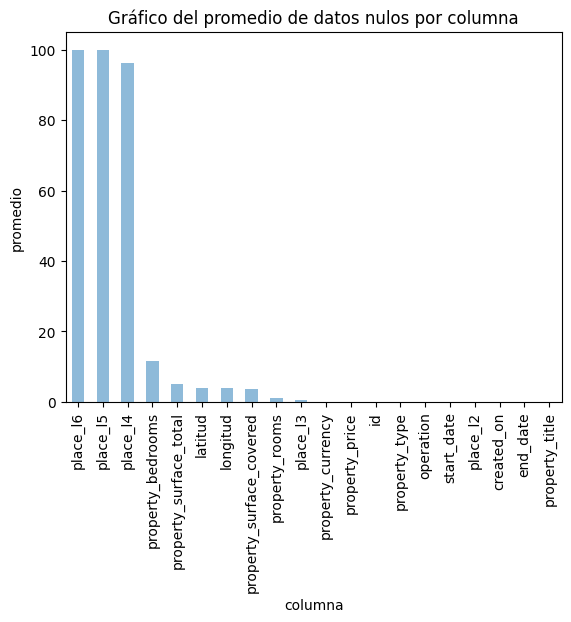

In [15]:
ds_porcentaje = promedio_datos_nulos
ds_porcentaje = ds_porcentaje.sort_values(ascending = False)
ds_porcentaje.plot.bar(alpha=0.5,title="Gráfico del promedio de datos nulos por columna", xlabel="columna" , ylabel="promedio")

Entonces los datos que debo analizar son:

In [16]:
def obtener_cantidad_nulos(ds):
  promedio_datos_nulos = obtener_promedio_nulos(ds)
  promedio_datos_nulos.sort_values(ascending = False,inplace=True)
  filtro = promedio_datos_nulos!=0
  return promedio_datos_nulos[filtro] if not promedio_datos_nulos[filtro].empty else 'No existen valores NaN'

obtener_cantidad_nulos(ds_train)

place_l6                    100.000000
place_l5                    100.000000
place_l4                     96.155121
property_bedrooms            11.687158
property_surface_total        5.156567
latitud                       3.907214
longitud                      3.907214
property_surface_covered      3.588907
property_rooms                1.091526
place_l3                      0.449608
dtype: float64

In [17]:
obtener_cantidad_nulos(ds_test)

place_l6                    100.000000
place_l5                    100.000000
place_l4                     96.053050
property_bedrooms            11.538462
property_surface_total        5.071618
latitud                       4.159151
longitud                      4.159151
property_surface_covered      3.437666
property_rooms                1.172414
place_l3                      0.413793
dtype: float64

####Elimino places (place_l6, place_l5, place_l4)

Al ver el gráfico y el análisis previo de nulos. Puedo eliminar las columnas ```place_l6```, ```place_l5``` y ```place_l4```, pues tienen en su totalidad de datos nulos. El ```place_l4``` tiene casi su totalidad de nulos.

Consideramos que las columnas ```place_l6```, ```place_l5``` son datos faltantes de tipo MCAR

In [18]:
columnas = ['place_l6','place_l5','place_l4']
ds_train.drop(columns=columnas, inplace=True)
ds_test.drop(columns=columnas, inplace=True)

In [19]:
ds_train.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
260196,Mls9WLcZ7ds/XoXLJSH0dA==,2021-04-14,2021-06-18,2021-04-14,-34.592759,-58.383464,Capital Federal,Retiro,Venta,Departamento,3.0,2.0,119.0,84.0,227000.0,USD,VENTA DEPARTAMENTO RECOLETA CON PATIO
301583,AIa+daa3G7Yb2XeBOcCfYQ==,2021-08-10,2021-12-13,2021-08-10,-34.588555,-58.387967,Capital Federal,Recoleta,Venta,Departamento,5.0,4.0,205.0,195.0,650000.0,USD,"Av. Alvear 1800, Recoleta - Piso elegante y lu..."
123449,/OMgM9cyLPXRcpCgnMyEEQ==,2021-08-04,9999-12-31,2021-08-04,-34.558849,-58.458606,Capital Federal,Belgrano,Venta,Departamento,3.0,2.0,77.0,77.0,200000.0,USD,3 ambientes con seguridad 24 hrs en el corazon...
391294,TOMQH5yZOvskYBUPJi1jbg==,2021-04-12,2021-04-30,2021-04-12,-34.581521,-58.449339,Capital Federal,Chacarita,Venta,Departamento,3.0,2.0,73.0,61.0,225000.0,USD,Venta Departamento 3 Amb. c/COCHERA
56136,nNAnxWblpISvRrMkFBg57g==,2021-04-09,2021-04-27,2021-04-09,-34.566708,-58.434404,Capital Federal,Palermo,Venta,Departamento,5.0,3.0,170.0,155.0,720000.0,USD,Las Cañitas SEMIPISO ESPECTACULAR 170 m2


In [20]:
ds_test.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
240363,U2ZerMjvQm4dFVfxLMWtUg==,2021-05-21,2021-06-05,2021-05-21,-34.613468,-58.369054,Capital Federal,San Telmo,Venta,Departamento,4.0,3.0,96.0,96.0,160000.0,USD,Departamento - San Telmo
140941,Mqq5TSUvhX3QPEKs3Tyfvg==,2021-10-31,2022-01-30,2021-10-31,-34.567318,-58.476828,Capital Federal,Villa Urquiza,Venta,PH,3.0,2.0,108.0,88.0,143000.0,USD,Venta PH 3 amb - Roosevelt 4000 - Villa Urquiza
223108,m8q60Y6X6L4ddTwXQtEjNg==,2021-01-17,2021-02-22,2021-01-17,-34.573707,-58.489148,Capital Federal,Villa Urquiza,Venta,Departamento,1.0,NaN,97.0,35.0,129000.0,USD,Venta- Monoambiente con Patio- Villa Urquiza- ...
61120,rtH+80/XPla1W8/LIPrARg==,2021-05-01,2021-06-05,2021-05-01,-34.553400,-58.485339,Capital Federal,Saavedra,Venta,PH,5.0,NaN,110.0,87.0,135000.0,USD,PH - Saavedra
339330,/jyT0VzUdb+DZNP1/FiZ6w==,2021-06-01,2021-06-05,2021-06-01,-34.623129,-58.426565,Capital Federal,Boedo,Venta,Departamento,2.0,1.0,49.0,41.0,125000.0,USD,Excelente 2 ambientes al fte c/balcón corrido ...


In [21]:
nulos_preimputacion = obtener_cantidad_nulos(ds_train)

In [22]:
obtener_cantidad_nulos(ds_test)

property_bedrooms           11.538462
property_surface_total       5.071618
latitud                      4.159151
longitud                     4.159151
property_surface_covered     3.437666
property_rooms               1.172414
place_l3                     0.413793
dtype: float64

####Generar funciones para análisis

In [23]:
# establezco si son o no nulos
def generar_ds_nulo(columnas):
  return ds_train[columnas].isna()

def filtrar_nulo(columna,ds):
  return ds[columna]==True

def filtrar_no_nulo(columna,ds):
  return ds[columna]==False

def aplicar_filtro(ds,filtro,columna,nulidad):
  ds.loc[filtro,columna] = nulidad
  return ds

In [24]:
def contar_ds(ds,columna):
  return ds[columna].value_counts()

def imprimir_cantidades(nulos,no_nulos,columna):
  print("Cantidad de datos NULOS en {}: {}".format(columna,nulos))
  print("Cantidad de datos NO NULOS en {}: {}".format(columna,no_nulos))

In [25]:
def generar_grafico(ds,columna):
  titulo = "Gráfico de barras: Cantidad de nulos en la variable " + columna
  ds[columna].value_counts().plot.bar(alpha=0.5,title=titulo, xlabel="tipo de dato" , ylabel="cantidad de filas")

####Latitud y longitud
Vamos a anlizar los nulos de estas dos variables

In [26]:
latatitud_longitud = generar_ds_nulo(['latitud','longitud'])
# filtros latitud
v_filtro_latitud = filtrar_nulo('latitud',latatitud_longitud)
f_filtro_latitud = filtrar_no_nulo('latitud',latatitud_longitud)
# filtros longitud
v_filtro_longitud = filtrar_nulo('longitud',latatitud_longitud)
f_filtro_longitud = filtrar_no_nulo('longitud',latatitud_longitud)
# aplico los filtros
latatitud_longitud = aplicar_filtro(latatitud_longitud,v_filtro_latitud,'latitud','nulo')
latatitud_longitud = aplicar_filtro(latatitud_longitud,f_filtro_latitud,'latitud','no nulo')

latatitud_longitud = aplicar_filtro(latatitud_longitud,v_filtro_longitud,'longitud','nulo')
latatitud_longitud = aplicar_filtro(latatitud_longitud,f_filtro_longitud,'longitud','no nulo')

latatitud_longitud.head()


,latitud,longitud
260196,no nulo,no nulo
301583,no nulo,no nulo
123449,no nulo,no nulo
391294,no nulo,no nulo
56136,no nulo,no nulo


In [27]:
cant_nulos_latitud,cant_no_nulos_latitud = contar_ds(latatitud_longitud,'latitud')
imprimir_cantidades(cant_nulos_latitud,cant_no_nulos_latitud,'latitud')

Cantidad de datos NULOS en latitud: 72453
Cantidad de datos NO NULOS en latitud: 2946


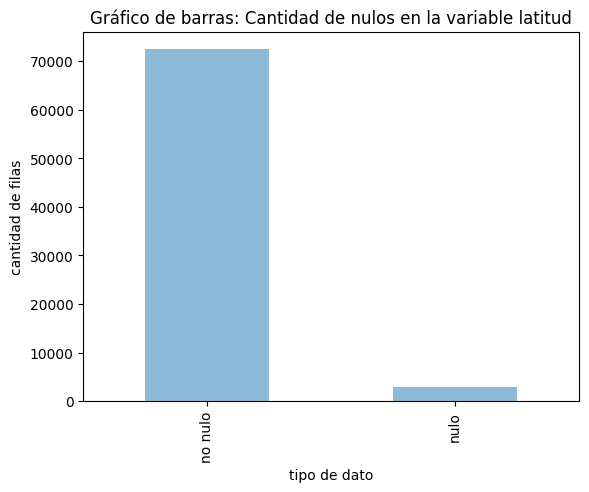

In [28]:
generar_grafico(latatitud_longitud,'latitud')

In [29]:
cant_nulos_longitud,cant_no_nulos_longitud = contar_ds(latatitud_longitud,'longitud')
imprimir_cantidades(cant_nulos_longitud,cant_no_nulos_longitud,'longitud')

Cantidad de datos NULOS en longitud: 72453
Cantidad de datos NO NULOS en longitud: 2946


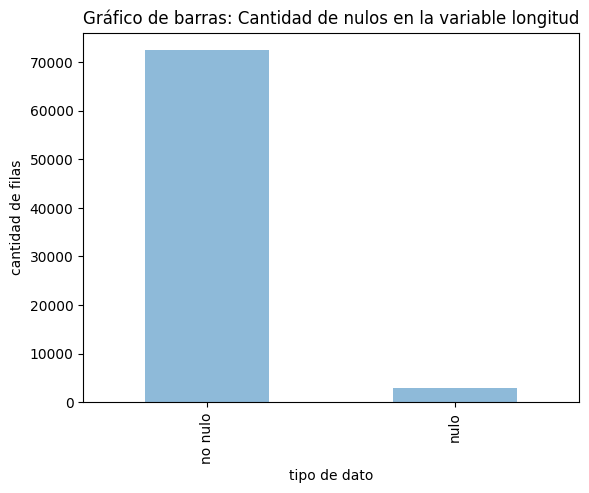

In [30]:
generar_grafico(latatitud_longitud,'longitud')

####Superficie total y Superficie cubierta (property_surface_total, property_surface_covered)

In [31]:
# establezco si son o no nulos
sup_total_cubierta = generar_ds_nulo(['property_surface_total','property_surface_covered'])
# creo filtro si son o no nulos
v_filtro_total =  filtrar_nulo('property_surface_total',sup_total_cubierta)
f_filtro_total =  filtrar_no_nulo('property_surface_total',sup_total_cubierta)

v_filtro_cubierto =  filtrar_nulo('property_surface_covered',sup_total_cubierta)
f_filtro_cubierto =  filtrar_no_nulo('property_surface_covered',sup_total_cubierta)
# establezco los nulos y no nulos
sup_total_cubierta = aplicar_filtro(sup_total_cubierta,v_filtro_total,'property_surface_total','nulo')
sup_total_cubierta = aplicar_filtro(sup_total_cubierta,f_filtro_total,'property_surface_total','no nulo')

# establezco los nulos y no nulos
sup_total_cubierta = aplicar_filtro(sup_total_cubierta,v_filtro_cubierto,'property_surface_covered','nulo')
sup_total_cubierta = aplicar_filtro(sup_total_cubierta,f_filtro_cubierto,'property_surface_covered','no nulo')

sup_total_cubierta.head()

,property_surface_total,property_surface_covered
260196,no nulo,no nulo
301583,no nulo,no nulo
123449,no nulo,no nulo
391294,no nulo,no nulo
56136,no nulo,no nulo


In [32]:
cant_nulos_total, cant_no_nulos_total = contar_ds(sup_total_cubierta,'property_surface_total')
imprimir_cantidades(cant_nulos_total,cant_no_nulos_total,'property_surface_total')

Cantidad de datos NULOS en property_surface_total: 71511
Cantidad de datos NO NULOS en property_surface_total: 3888


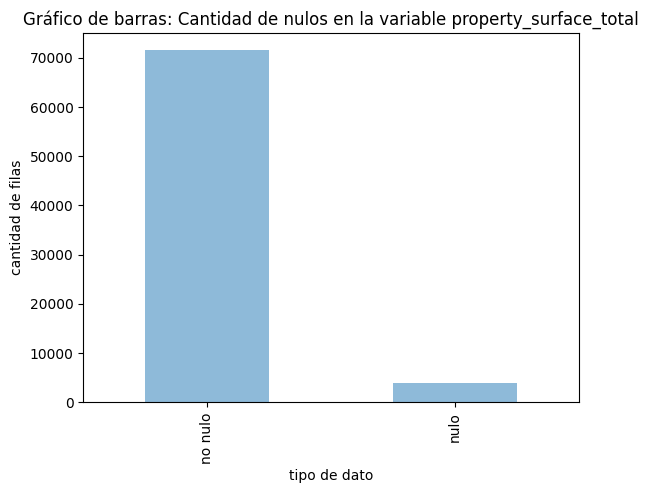

In [33]:
generar_grafico(sup_total_cubierta,'property_surface_total')

In [34]:
cant_nulos_total, cant_no_nulos_total = contar_ds(sup_total_cubierta,'property_surface_covered')
imprimir_cantidades(cant_nulos_total,cant_no_nulos_total,'property_surface_covered')

Cantidad de datos NULOS en property_surface_covered: 72693
Cantidad de datos NO NULOS en property_surface_covered: 2706


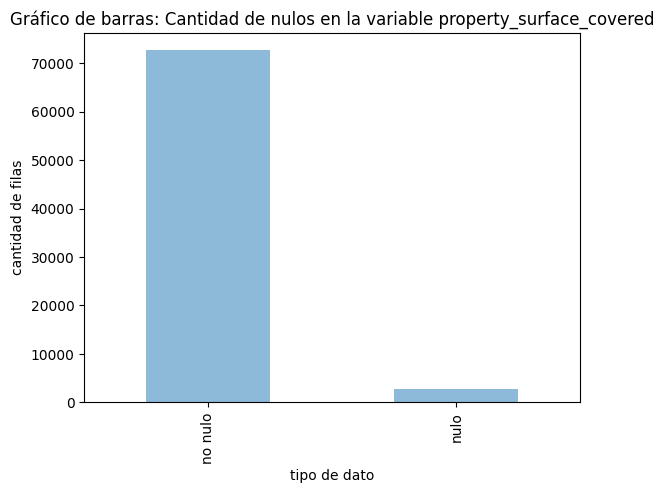

In [35]:
generar_grafico(sup_total_cubierta,'property_surface_covered')

####Habitaciones y dormitorios (property_rooms, property_bedrooms)

In [36]:
# establezco si son o no nulos
habitaciones_dormis = generar_ds_nulo(['property_rooms','property_bedrooms'])
# creo filtro si son o no nulos
v_filtro_hab = filtrar_nulo('property_rooms',habitaciones_dormis)
f_filtro_hab =  filtrar_no_nulo('property_rooms',habitaciones_dormis)

v_filtro_dormis =  filtrar_nulo('property_bedrooms',habitaciones_dormis)
f_filtro_dormis =  filtrar_no_nulo('property_bedrooms',habitaciones_dormis)

# establezco los nulos y no nulos
habitaciones_dormis = aplicar_filtro(habitaciones_dormis,v_filtro_hab,'property_rooms','nulo')
habitaciones_dormis = aplicar_filtro(habitaciones_dormis,f_filtro_hab,'property_rooms','no nulo')

# establezco los nulos y no nulos
habitaciones_dormis = aplicar_filtro(habitaciones_dormis,v_filtro_dormis,'property_bedrooms','nulo')
habitaciones_dormis = aplicar_filtro(habitaciones_dormis,f_filtro_dormis,'property_bedrooms','no nulo')

habitaciones_dormis.head()

,property_rooms,property_bedrooms
260196,no nulo,no nulo
301583,no nulo,no nulo
123449,no nulo,no nulo
391294,no nulo,no nulo
56136,no nulo,no nulo


In [37]:
cant_nulos_total, cant_no_nulos_total = contar_ds(habitaciones_dormis,'property_rooms')
imprimir_cantidades(cant_nulos_total,cant_no_nulos_total,'property_rooms')

Cantidad de datos NULOS en property_rooms: 74576
Cantidad de datos NO NULOS en property_rooms: 823


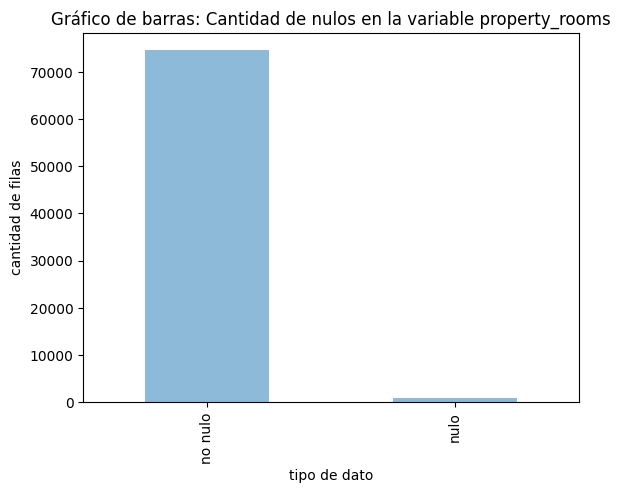

In [38]:
generar_grafico(habitaciones_dormis,'property_rooms')

In [39]:
cant_nulos_total, cant_no_nulos_total = contar_ds(habitaciones_dormis,'property_bedrooms')
imprimir_cantidades(cant_nulos_total,cant_no_nulos_total,'property_bedrooms')

Cantidad de datos NULOS en property_bedrooms: 66587
Cantidad de datos NO NULOS en property_bedrooms: 8812


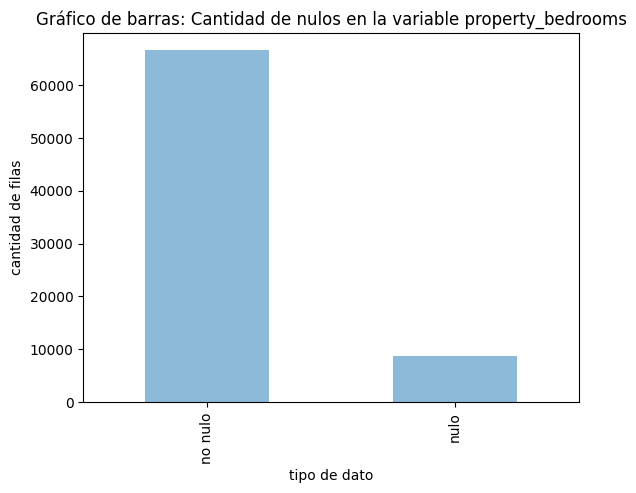

In [40]:
generar_grafico(habitaciones_dormis,'property_bedrooms')

####Barrio (place_l3)

In [41]:
# establezco si son o no nulos
barrio = generar_ds_nulo('place_l3')
# creo filtro si son o no nulos
v_filtro_barrio =  barrio == True
f_filtro_barrio =  barrio == False
# establezco los nulos y no nulos
barrio.loc[v_filtro_barrio] = 'nulo'
barrio.loc[f_filtro_barrio] = 'no nulo'

barrio.head()

260196    no nulo
301583    no nulo
123449    no nulo
391294    no nulo
56136     no nulo
Name: place_l3, dtype: object

In [42]:
cant_nulos_barrio,cant_no_nulos_barrio = barrio.value_counts()
imprimir_cantidades(cant_nulos_total,cant_no_nulos_total,'place_l3')

Cantidad de datos NULOS en place_l3: 66587
Cantidad de datos NO NULOS en place_l3: 8812


<Axes: title={'center': 'Gráfico de barras: Cantidad de nulos en la variable place_l3'}, xlabel='tipo de dato', ylabel='cantidad de filas'>

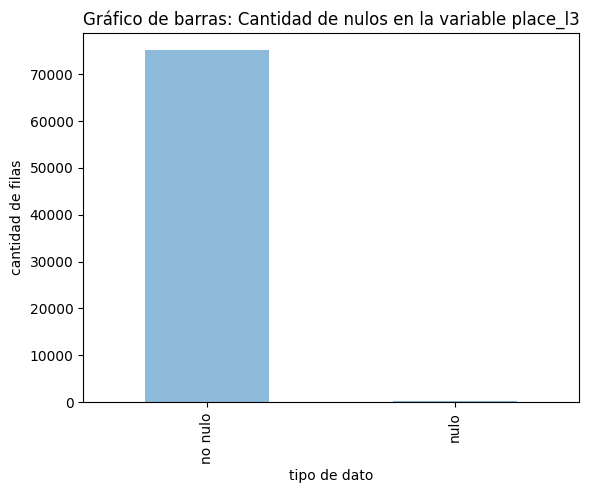

In [43]:
barrio.value_counts().plot.bar(alpha=0.5,title="Gráfico de barras: Cantidad de nulos en la variable place_l3", xlabel="tipo de dato" , ylabel="cantidad de filas")

####Precio

In [44]:
precio = generar_ds_nulo('property_price')
# creo filtro si son o no nulos
v_filtro_precio =  precio == True
f_filtro_precio =  precio == False
# establezco los nulos y no nulos
precio.loc[v_filtro_precio] = 'nulo'
precio.loc[f_filtro_precio] = 'no nulo'

precio.head()

260196    no nulo
301583    no nulo
123449    no nulo
391294    no nulo
56136     no nulo
Name: property_price, dtype: object

In [45]:
print("Cantidad de datos NO NULOS en property_price: {}".format(precio.value_counts()))

Cantidad de datos NO NULOS en property_price: no nulo    75399
Name: property_price, dtype: int64


<Axes: title={'center': 'Gráfico de barras: Cantidad de nulos en la variable property_price'}, xlabel='tipo de dato', ylabel='cantidad de filas'>

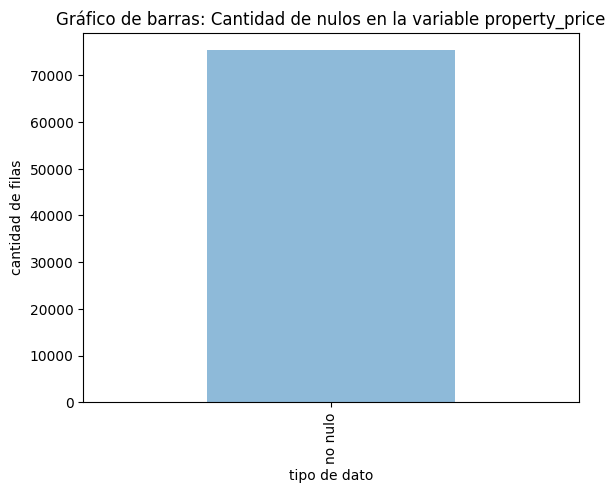

In [46]:
precio.value_counts().plot.bar(alpha=0.5,title="Gráfico de barras: Cantidad de nulos en la variable property_price", xlabel="tipo de dato" , ylabel="cantidad de filas")

###Análisis de datos faltantes a nivel fila

Realizar un análisis de datos faltantes a nivel de fila. Calcular el porcentaje de datos
faltantes de cada registro. Realizar un gráfico que permita conocer la proporción de
faltantes por fila en el dataset.


In [47]:
# Calcular la cantidad de filas nulas
cantidad_filas_nulas = ds_train.isna().sum(axis=1)
filtro = cantidad_filas_nulas > 0
cantidad_filas_nulas = cantidad_filas_nulas[filtro]
print("La cantidad de filas que tienen al menos un dato nulo es: ",len(cantidad_filas_nulas))

La cantidad de filas que tienen al menos un dato nulo es:  17123


<Axes: title={'center': 'Gráfico de barras: Cantidad de filas nulas en ds_train'}, xlabel='cantidad de nulos', ylabel='cantidad de filas'>

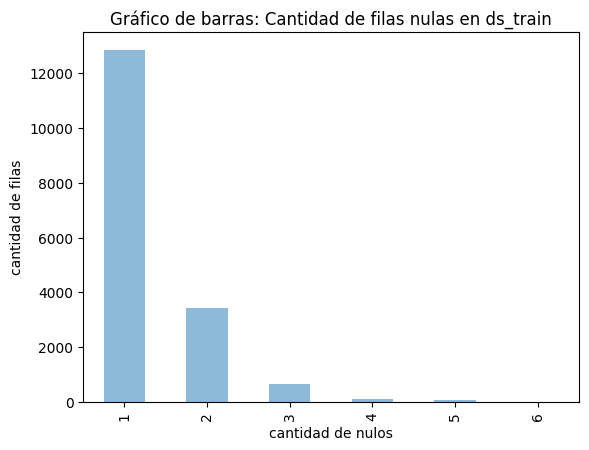

In [48]:
cantidad_filas_nulas.value_counts().plot.bar(alpha=0.5,title="Gráfico de barras: Cantidad de filas nulas en ds_train", xlabel="cantidad de nulos" , ylabel="cantidad de filas")

###Revisión de datos faltantes o mal ingresados

Revisar los datos faltantes o mal ingresados y tomar una decisión sobre estos: reemplazo de
valores, eliminación de registros incompletos, etc.

Recordemos los datos nulos que tenemos en ds_train

In [49]:
obtener_cantidad_nulos(ds_train)

property_bedrooms           11.687158
property_surface_total       5.156567
latitud                      3.907214
longitud                     3.907214
property_surface_covered     3.588907
property_rooms               1.091526
place_l3                     0.449608
dtype: float64

Veremos unas de las estrategias para para trabajar con datos faltantes. Procederemos a imputar datos

####Imputación Cold Deck
Vamos a trabajar con los datos ```latitud``` y ```longitud``` para completar la variable ```place_l3```.
Para ello vamos a utilizar el csv ```barrios.csv``` provisto por [GCBA](https://data.buenosaires.gob.ar/dataset/barrios/resource/juqdkmgo-191-resource) que nos da la localización y límites geográficos de los barrios de la Ciudad.

Antes de imputar vamos a hacer una copia para analizar la imputación en el siguiente punto.

In [50]:
ds_pre_imputacion = ds_train.copy()

Para ello vamos a usar Geopandas correspondiente a la documentación wkt

In [51]:
file_path = '/content/drive/MyDrive/7506R-1C2024-GRUPO02/Dataset/barrios.csv'

ds_barrios = pd.read_csv(file_path, header=0,sep=';')
def completar_barrios(ds):
  for index, propiedad in ds.iterrows():
    if isinstance(propiedad["place_l3"], str):
      continue

    for index,barrio in ds_barrios.iterrows():
      barrio_aux = barrio['BARRIO']
      if barrio_aux == '' or barrio_aux is None:
        continue
      coordenada = Point(propiedad['longitud'],propiedad['latitud'])
      # uso wkt Para deserializar una cadena y obtener un nuevo objeto geométrico del tipo apropiado
      # uso covers para ver si está cubierta la coordenada de ds_barrios por lo que tiene mi ds
      if wkt.loads(barrio['WKT']).covers(coordenada):
        ds.loc[index,'place_l3'] = barrio_aux

  return

completar_barrios(ds_train)
completar_barrios(ds_test)

Visualizamos el dataset para ver si podemos ver algún nulo rápido.

In [52]:
# Ordenar el DataFrame por 'place_l3'
ds_train_sorted = ds_train.sort_values(by='place_l3')

# Extraer la columna 'place_l3'
place_l3_column = ds_train_sorted['place_l3']

# Elimino la columna 'place_l3' del DataFrame
ds_train_sorted.drop(columns=['place_l3'], inplace=True)

# Inserto la columna 'place_l3' en la primera posición
ds_train_sorted.insert(0, 'place_l3', place_l3_column)

# Ahora ds_train_sorted tiene 'place_l3' como la primera columna
# para visualizarlo mejor
ds_train_sorted

,place_l3,id,start_date,end_date,created_on,latitud,longitud,place_l2,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
27,AGRONOMIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ALMAGRO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182690,Abasto,vQ2hgZLRmkxjCWM6UuvKCA==,2021-12-21,9999-12-31,2021-12-21,-34.602170,-58.412383,Capital Federal,Venta,Departamento,2.0,1.0,40.0,40.0,84000.0,USD,EXCELENTE 2 AMBIENTES / Vista abierta al Frent...
124253,Abasto,P62b3IKueqvB2qUsP/BsOg==,2021-11-26,2021-12-15,2021-11-26,-34.604245,-58.413048,Capital Federal,Venta,Departamento,4.0,3.0,110.0,100.0,335000.0,USD,Oportunidad Dpto. 4 ambientes con cochera y ba...
352367,Abasto,RgaA6RJyxwConG5in1I35w==,2021-06-25,2022-06-08,2021-06-25,-34.603501,-58.408680,Capital Federal,Venta,Departamento,1.0,1.0,34.0,31.0,68000.0,USD,DEPTO 1 AMBIENTE CON BALCON CFTE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44904,NaN,FMuIW0cVEZuu00r4iMZGlw==,2021-01-26,2021-11-04,2021-01-26,NaN,NaN,Capital Federal,Venta,Departamento,2.0,NaN,NaN,57.0,110000.0,USD,Departamento en Venta CABA / Buenos Aires (D03...
45552,NaN,Zkea9YlQ0d1zEm3zEaOrTQ==,2021-05-02,2021-06-05,2021-05-02,-31.474609,-64.538326,Capital Federal,Venta,Casa,5.0,3.0,700.0,200.0,165000.0,USD,Hermosa casa en venta barrio cerrado Lomas Del...
134800,NaN,523CC8zAk8rc05AJBl1IaA==,2021-04-06,2021-11-04,2021-04-06,NaN,NaN,Capital Federal,Venta,Departamento,1.0,NaN,NaN,46.0,96000.0,USD,Departamento venta o permuta en Buenos Aires c...
130483,NaN,Ugb7T6AVz6r+gRe7w5KpSA==,2021-05-27,2021-06-05,2021-05-27,-31.616671,-60.599998,Capital Federal,Venta,Casa,NaN,1.0,500.0,89.0,55000.0,USD,VENDO CASA EN BARRIO LAS PALTAS


Vemos que hay datos NaN en el barrio

In [53]:
ds_train['place_l3'].isna().value_counts()

False    75080
True       339
Name: place_l3, dtype: int64

Estos datos en NaN pueden ser datos mal ingresados. Se ingresó mal la coordenada de la propiedad y se la clasificó como Capital Federal. Lo mismo puede suceder de que no tengan latitud ni longitud. Procedo a eliminar dichos datos

In [54]:
columnas_a_eliminar = ['latitud','longitud','place_l3']
ds_train = ds_train.dropna(subset=columnas_a_eliminar)
ds_test =  ds_test.dropna(subset=columnas_a_eliminar)

Verifico mis datos_nulos en mi dataset

In [55]:
obtener_cantidad_nulos(ds_train)

property_bedrooms           11.577534
property_surface_total       5.069756
property_surface_covered     3.548691
property_rooms               0.932846
dtype: float64

####Análisis de property's
Ahora vamos a seguir con el análisis de las siguientes variables:
*     property_bedrooms
*     property_rooms
*     property_surface_total
*     property_surface_covered

Podemos identificar que estas variables son tipos de datos faltantes MAR.

#####Análisis de ceros

Para empezar verifico si alguno de estos datos es negativo. Pues valores negativos para alguno de estos atributos no tiene sentido.

In [56]:
columnas_con_numeros = ['property_bedrooms','property_rooms','property_surface_total','property_surface_covered']
(ds_train[columnas_con_numeros] <= 0).any().to_frame("Menor o igual que 0 ?")

,Menor o igual que 0 ?
property_bedrooms,True
property_rooms,False
property_surface_total,False
property_surface_covered,False


Vemos que existen valores menores o iguales que 0 en el atributo ```property_bedrooms```. Procedo a ver cuantos registros cumplen con esta condición.

In [57]:
filtro = ds_propiedades_filtradas['property_bedrooms'] < 1
ds_propiedades_filtradas[filtro]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
406880,3WI+zCCMeb9TR5kOBm7rhg==,2021-01-07,2021-03-18,2021-01-07,-34.577595,-58.495185,Capital Federal,Villa Urquiza,NaN,NaN,NaN,Venta,Departamento,2.0,-1.0,61.0,43.0,125000.0,USD,Jardines de Roosevelt - Hermoso 3 ambientes co...


Como hay un registro, procedo a asignarlo nulo.

In [58]:
ds_train.loc[filtro,'property_bedrooms'] = np.nan

Verifico si hay valores menores o iguales que cero.

In [59]:
columnas_con_numeros = ['property_bedrooms','property_rooms','property_surface_total','property_surface_covered']
(ds_train[columnas_con_numeros] <= 0).any().to_frame("Menor o igual que 0 ?")

,Menor o igual que 0 ?
property_bedrooms,False
property_rooms,False
property_surface_total,False
property_surface_covered,False


Realizo el mismo análisis con ds_test

In [60]:
columnas_con_numeros = ['property_bedrooms','property_rooms','property_surface_total','property_surface_covered']
(ds_test[columnas_con_numeros] <= 0).any().to_frame("Menor o igual que 0 ?")

,Menor o igual que 0 ?
property_bedrooms,False
property_rooms,False
property_surface_total,False
property_surface_covered,False


#####Análisis de duplicados

Verifico si hay datos duplicados en estas columnas

In [61]:
ds_train[ds_train.duplicated(keep=False)]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title


In [62]:
ds_test[ds_test.duplicated(keep=False)]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title


Procedo a eliminar filas duplicadas

In [63]:
size_antes = len(ds_train)
ds_train_filtrado = ds_train.drop_duplicates()
size_despues = len(ds_train_filtrado)
print(f"Se eliminaron: {size_antes-size_despues} filas duplicadas de ds_train")

Se eliminaron: 0 filas duplicadas de ds_train


In [64]:
ds_train_filtrado.reset_index(drop=True, inplace=True)

In [65]:
size_antes = len(ds_test)
ds_test_filtrado = ds_test.drop_duplicates()
size_despues = len(ds_test_filtrado)
print(f"Se eliminaron: {size_antes-size_despues} filas duplicadas de ds_test")

Se eliminaron: 0 filas duplicadas de ds_test


In [66]:
ds_test_filtrado.reset_index(drop=True, inplace=True)

#####Completo las columnas de forma multivariada

Como las variables faltantes son datos de tipo MAR (Missing At Random), elijo el proceso de imputación de datos MICE (Multivariate Imputation by Chained Equations)

In [67]:
# la variable columnas_con_numeros tiene las columnas a analizar
lr = LinearRegression()
imp = IterativeImputer(
    estimator=lr,
    missing_values = np.nan,
    max_iter = 20,
    verbose = 0,
    random_state = 0,
    min_value = 1
)


def rellenar_variables(ds,columnas):
  df_eliminar_nans_op3_completo = ds[columnas].copy()
  ds[columnas] = imp.fit_transform(df_eliminar_nans_op3_completo)

rellenar_variables(ds_train,columnas_con_numeros)


<ipython-input-67-72180959683a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds[columnas] = imp.fit_transform(df_eliminar_nans_op3_completo)


In [68]:
obtener_promedio_nulos(ds_train)

id                          0.0
start_date                  0.0
end_date                    0.0
created_on                  0.0
latitud                     0.0
longitud                    0.0
place_l2                    0.0
place_l3                    0.0
operation                   0.0
property_type               0.0
property_rooms              0.0
property_bedrooms           0.0
property_surface_total      0.0
property_surface_covered    0.0
property_price              0.0
property_currency           0.0
property_title              0.0
dtype: float64

In [69]:
obtener_cantidad_nulos(ds_train)

'No existen valores NaN'

###Comparación de distribuciones
En caso de realizar imputaciones comparar las distribuciones de cada atributo reparado con
la distribución anterior a la imputación de los datos faltantes.

Para ello veamos nuestro ```ds_pre_imputacion```

In [70]:
ds_pre_imputacion.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
260196,Mls9WLcZ7ds/XoXLJSH0dA==,2021-04-14,2021-06-18,2021-04-14,-34.592759,-58.383464,Capital Federal,Retiro,Venta,Departamento,3.0,2.0,119.0,84.0,227000.0,USD,VENTA DEPARTAMENTO RECOLETA CON PATIO
301583,AIa+daa3G7Yb2XeBOcCfYQ==,2021-08-10,2021-12-13,2021-08-10,-34.588555,-58.387967,Capital Federal,Recoleta,Venta,Departamento,5.0,4.0,205.0,195.0,650000.0,USD,"Av. Alvear 1800, Recoleta - Piso elegante y lu..."
123449,/OMgM9cyLPXRcpCgnMyEEQ==,2021-08-04,9999-12-31,2021-08-04,-34.558849,-58.458606,Capital Federal,Belgrano,Venta,Departamento,3.0,2.0,77.0,77.0,200000.0,USD,3 ambientes con seguridad 24 hrs en el corazon...
391294,TOMQH5yZOvskYBUPJi1jbg==,2021-04-12,2021-04-30,2021-04-12,-34.581521,-58.449339,Capital Federal,Chacarita,Venta,Departamento,3.0,2.0,73.0,61.0,225000.0,USD,Venta Departamento 3 Amb. c/COCHERA
56136,nNAnxWblpISvRrMkFBg57g==,2021-04-09,2021-04-27,2021-04-09,-34.566708,-58.434404,Capital Federal,Palermo,Venta,Departamento,5.0,3.0,170.0,155.0,720000.0,USD,Las Cañitas SEMIPISO ESPECTACULAR 170 m2


Recordemos que datos imputamos

In [71]:
nulos_preimputacion

property_bedrooms           11.687158
property_surface_total       5.156567
latitud                      3.907214
longitud                     3.907214
property_surface_covered     3.588907
property_rooms               1.091526
place_l3                     0.449608
dtype: float64

In [72]:
nulos_preimputacion.index.tolist()

['property_bedrooms',
 'property_surface_total',
 'latitud',
 'longitud',
 'property_surface_covered',
 'property_rooms',
 'place_l3']

Para ver la distribuciones de las variables imputadas vamos a utilizar un gráfico de distribución continua BoxPlot. El cual nos va a ayudar a visualizar la distribución de los datos y la asimetría de los mismos mediante la visualización de cuartiles y promedios de los datos.

####Funciones de distribución

In [73]:
def generar_distribucion(variable):
  # Crear una cuadrícula de subgráficos con una fila y dos columnas
  fig, axes = plt.subplots(1, 2, figsize=(12, 12))

  # Trazar el boxplot para ds_pre_imputacion en el primer subgráfico
  sns.boxplot(y=variable, data=ds_pre_imputacion, ax=axes[0])
  axes[0].set_title("Boxplot {} pre-imputacion".format(variable))

  # Trazar el boxplot para ds_train en el segundo subgráfico
  sns.boxplot(y=variable, data=ds_train, ax=axes[1])
  axes[1].set_title("Boxplot {} post-imputacion".format(variable))

  # Ajustar el diseño
  plt.tight_layout()

  # Mostrar los gráficos
  plt.show()
  return

In [74]:
def generar_distribucion_zoom(variable):
  # Crear una cuadrícula de subgráficos con una fila y dos columnas
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))

  # Trazar el boxplot para ds_pre_imputacion en el primer subgráfico
  sns.boxplot(y=variable, data=ds_pre_imputacion, ax=axes[0])
  axes[0].set_title("Boxplot {} pre-imputacion".format(variable))
  axes[0].set_ylim(0, 10)  # Ajustar el rango del eje y

  # Trazar el boxplot para ds_train en el segundo subgráfico
  sns.boxplot(y=variable, data=ds_train, ax=axes[1])
  axes[1].set_title("Boxplot {} post-imputacion".format(variable))
  axes[1].set_ylim(0, 10)  # Ajustar el rango del eje y

  # Ajustar el diseño
  plt.tight_layout()

  # Mostrar los gráficos
  plt.show()
  return

In [75]:
def obtener_cantidad_variables(ds,columna):
  analisis = ds[columna].value_counts().reset_index()
  analisis.columns = [columna, 'cantidad']
  return analisis

In [76]:
def comparar_imputacion(pre, post, columna):
    for i in range(len(pre)):
        registros_imputados = post['cantidad'][i] - pre['cantidad'][i]
        registros_imputados = abs(registros_imputados)  # Tomar el valor absoluto
        print("{} registros se imputaron con el valor de {} {}".format(registros_imputados, pre[columna][i], columna))
    return

####Comparación property_bedrooms

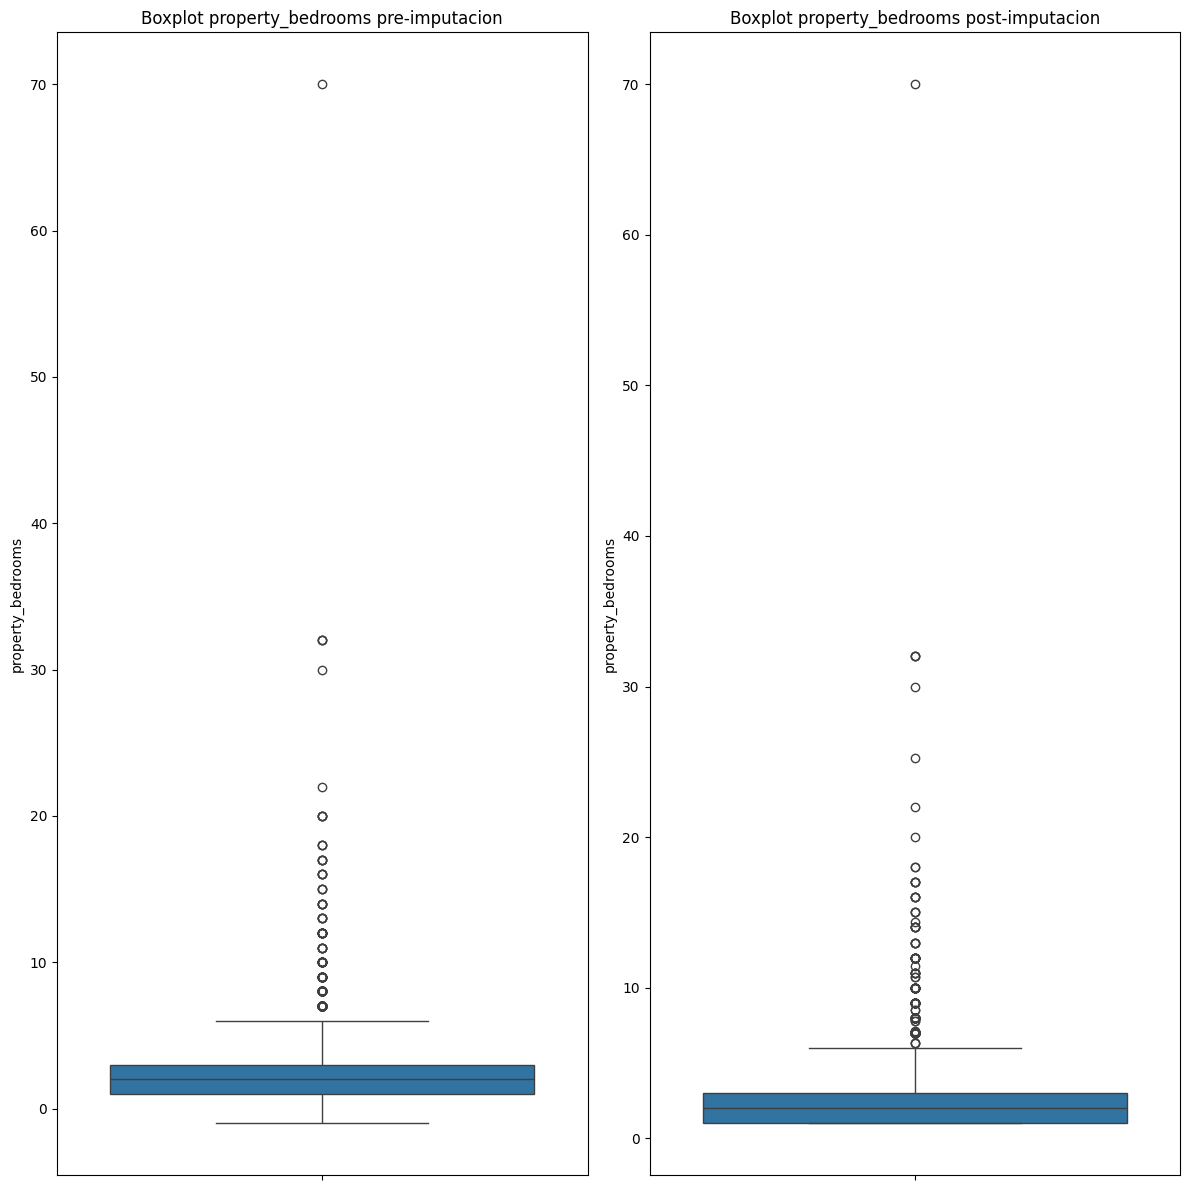

In [77]:
generar_distribucion("property_bedrooms")

Un poco de zoom

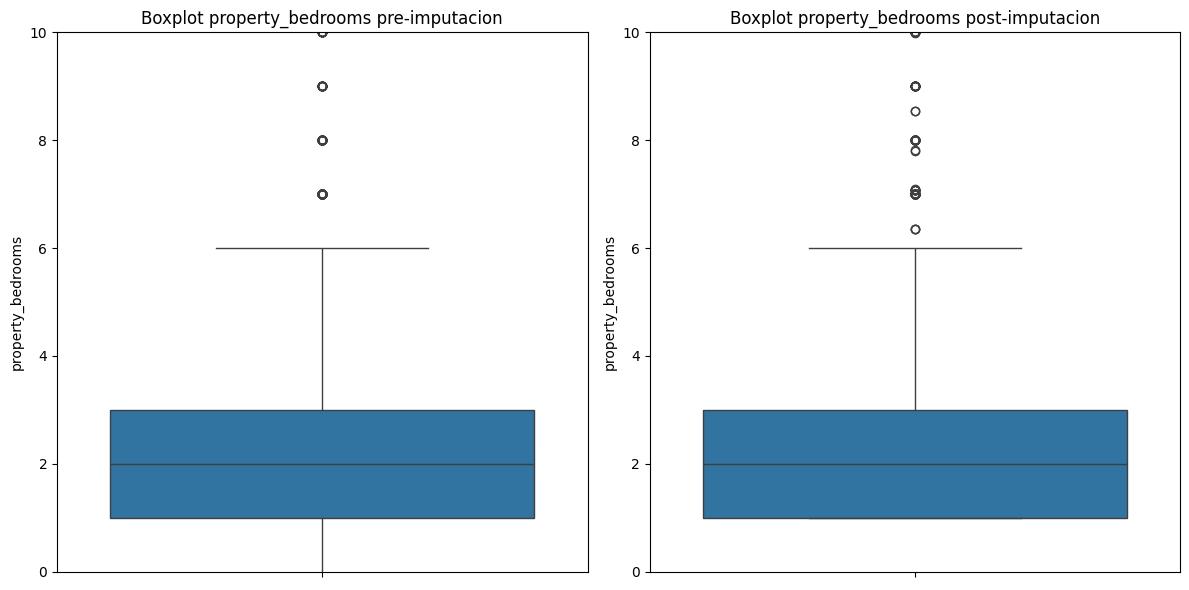

In [78]:
generar_distribucion_zoom("property_bedrooms")

La comparación de los boxplots revela una gran coherencia en la distribución de la variable entre los conjuntos de datos antes y después de la imputación. Aunque se observa una discrepancia leve entre los valores de aproximadamente 20 y 30, esta diferencia es mínima en comparación con la totalidad de los datos. Esto sugiere que las imputaciones se realizaron de manera consistente y dentro de los límites razonables de la variable, sin introducir valores atípicos o extremos.

Vamos a analizar cada property_bedrooms

In [79]:
pre_bedrooms = obtener_cantidad_variables(ds_pre_imputacion,'property_bedrooms')
pre_bedrooms.head()

,property_bedrooms,cantidad
0,1.0,25521
1,2.0,21836
2,3.0,14191
3,4.0,3875
4,5.0,747


In [80]:
post_bedrooms = obtener_cantidad_variables(ds_train,'property_bedrooms')
post_bedrooms.head()

,property_bedrooms,cantidad
0,1.0,31940
1,2.0,21043
2,3.0,13541
3,4.0,3663
4,5.0,686


Con esto podemos ver la cantidad de imputaciones que se hicieron gracias al método MICE.

In [81]:
comparar_imputacion(pre_bedrooms,post_bedrooms,'property_bedrooms')

6419 registros se imputaron con el valor de 1.0 property_bedrooms
793 registros se imputaron con el valor de 2.0 property_bedrooms
650 registros se imputaron con el valor de 3.0 property_bedrooms
212 registros se imputaron con el valor de 4.0 property_bedrooms
61 registros se imputaron con el valor de 5.0 property_bedrooms
18 registros se imputaron con el valor de 6.0 property_bedrooms
4 registros se imputaron con el valor de 7.0 property_bedrooms
1 registros se imputaron con el valor de 8.0 property_bedrooms
1 registros se imputaron con el valor de 9.0 property_bedrooms
0 registros se imputaron con el valor de 10.0 property_bedrooms
0 registros se imputaron con el valor de 12.0 property_bedrooms
5 registros se imputaron con el valor de 14.0 property_bedrooms
2 registros se imputaron con el valor de 11.0 property_bedrooms
3 registros se imputaron con el valor de 16.0 property_bedrooms
3 registros se imputaron con el valor de 20.0 property_bedrooms
3 registros se imputaron con el valor 

Podemos concluir que la mayoría de los datos nulos en la variable property_bedrooms fueron llenados con la cantidad de un dormitorio

####Comparación property_rooms

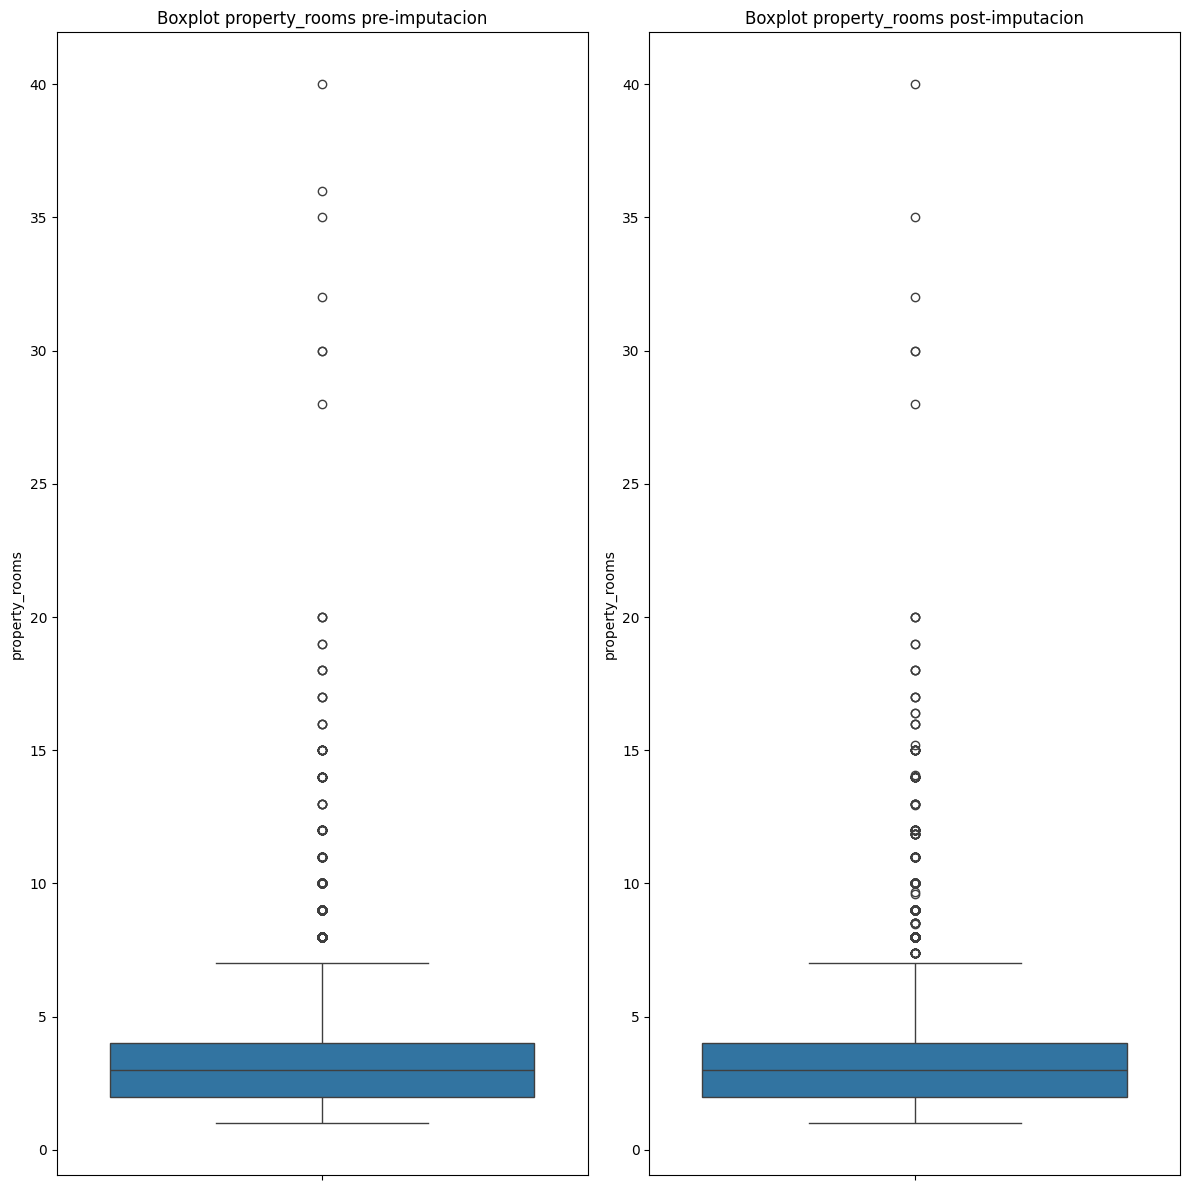

In [82]:
generar_distribucion("property_rooms")

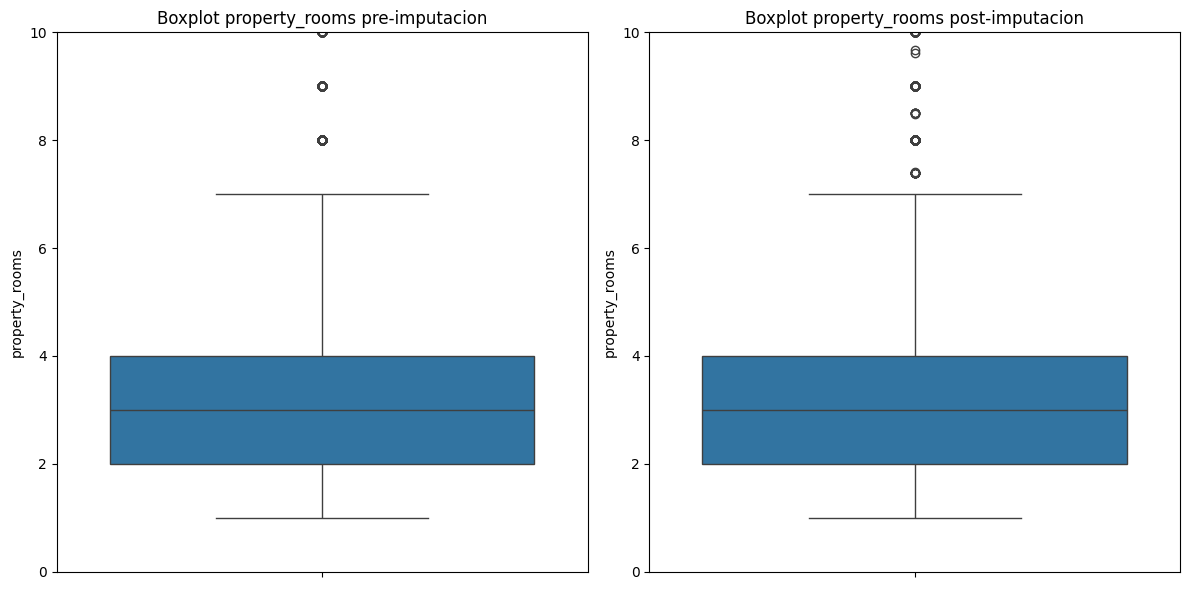

In [83]:
generar_distribucion_zoom("property_rooms")

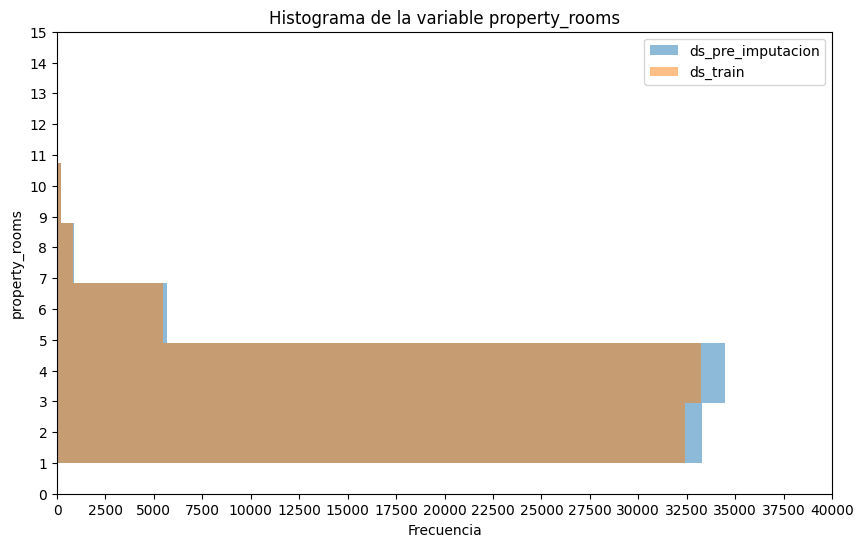

In [84]:
# Trama dos histogramas en la misma figura
plt.figure(figsize=(10, 6))

# Histograma para ds_pre_imputacion en el eje y (invertido)
plt.hist(ds_pre_imputacion['property_rooms'], bins=20, alpha=0.5, orientation='horizontal', label='ds_pre_imputacion')

# Histograma para ds_train en el eje y (invertido)
plt.hist(ds_train['property_rooms'], bins=20, alpha=0.5, orientation='horizontal', label='ds_train')

# Añadir título y etiquetas de los ejes
plt.title("Histograma de la variable property_rooms")
plt.xlabel("Frecuencia")
plt.ylabel("property_rooms")

# Establecer los límites de los ejes (zoom)
plt.ylim(0, 15)  # Límites y desde 0 hasta 15
plt.xlim(0, 40000)  # Límites x desde 0 hasta 40000

# Establecer los ticks del eje x en intervalos de 2500
plt.xticks(np.arange(0, 40001, 2500))

# Añadir leyenda
plt.legend()

# Establecer los ticks del eje y de 0 a 15, uno a uno
plt.yticks(np.arange(16))

# Mostrar el gráfico
plt.show()

<Axes: >

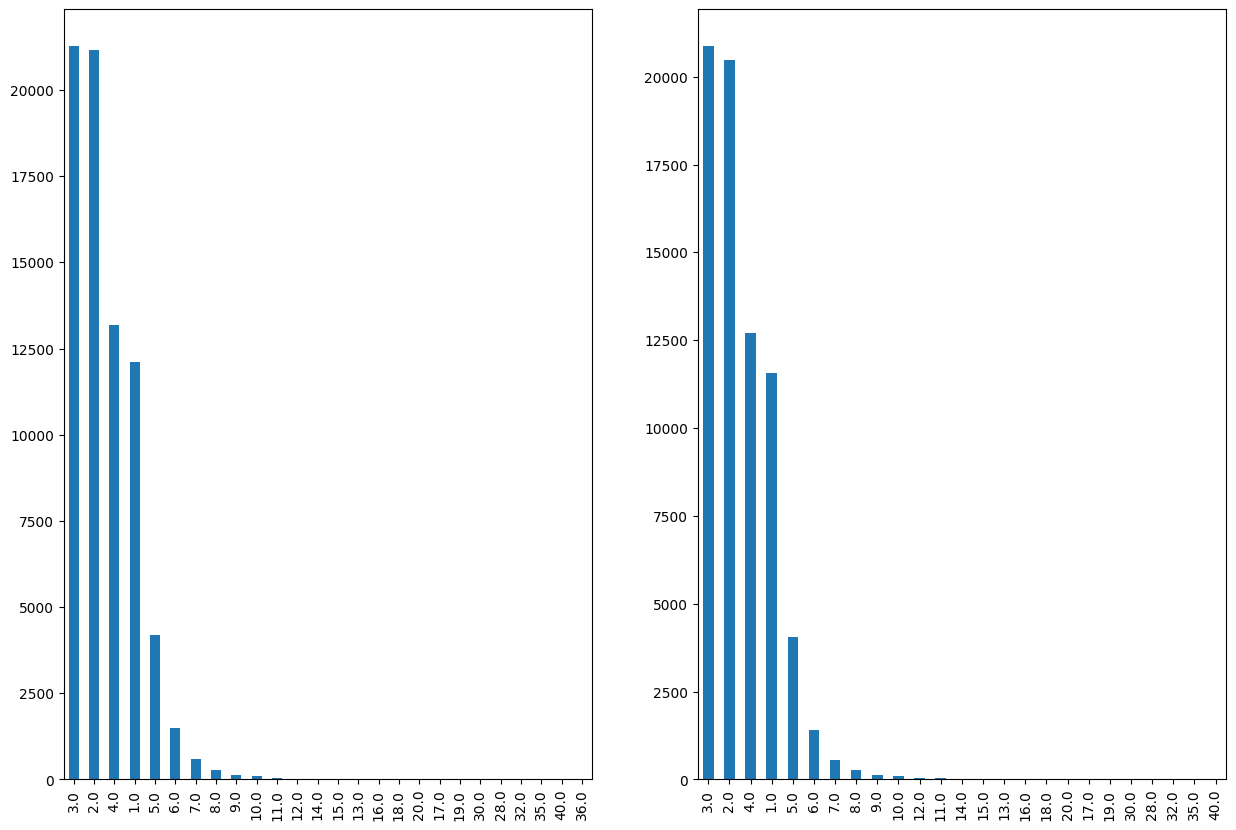

In [85]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15,10)
ds_pre_imputacion["property_rooms"].value_counts().plot.bar(ax=axes[0])
ds_train["property_rooms"].round().value_counts().plot.bar(ax=axes[1])

A través de estos gráficos, se observan sutiles discrepancias al asignar la cantidad de habitaciones a la hora de realizar la imputación.

In [86]:
pre_rooms = obtener_cantidad_variables(ds_pre_imputacion,'property_rooms')
pre_rooms.head()

,property_rooms,cantidad
0,3.0,21276
1,2.0,21169
2,4.0,13182
3,1.0,12098
4,5.0,4184


In [87]:
post_rooms = obtener_cantidad_variables(ds_train,'property_rooms')
post_rooms.head()

,property_rooms,cantidad
0,3.0,20514
1,2.0,20412
2,4.0,12593
3,1.0,11576
4,5.0,3977


In [88]:
comparar_imputacion(pre_rooms,post_rooms,'property_rooms')

762 registros se imputaron con el valor de 3.0 property_rooms
757 registros se imputaron con el valor de 2.0 property_rooms
589 registros se imputaron con el valor de 4.0 property_rooms
522 registros se imputaron con el valor de 1.0 property_rooms
207 registros se imputaron con el valor de 5.0 property_rooms
106 registros se imputaron con el valor de 6.0 property_rooms
36 registros se imputaron con el valor de 7.0 property_rooms
11 registros se imputaron con el valor de 8.0 property_rooms
2 registros se imputaron con el valor de 9.0 property_rooms
5 registros se imputaron con el valor de 10.0 property_rooms
0 registros se imputaron con el valor de 11.0 property_rooms
0 registros se imputaron con el valor de 12.0 property_rooms
0 registros se imputaron con el valor de 14.0 property_rooms
0 registros se imputaron con el valor de 15.0 property_rooms
5 registros se imputaron con el valor de 13.0 property_rooms
4 registros se imputaron con el valor de 16.0 property_rooms
4 registros se impu

Podemos inferir que la mayoría de los valores faltantes en la variable "property_rooms" fueron sustituidos por la cantidad de dos habitaciones.

####Comparación property_surface_total

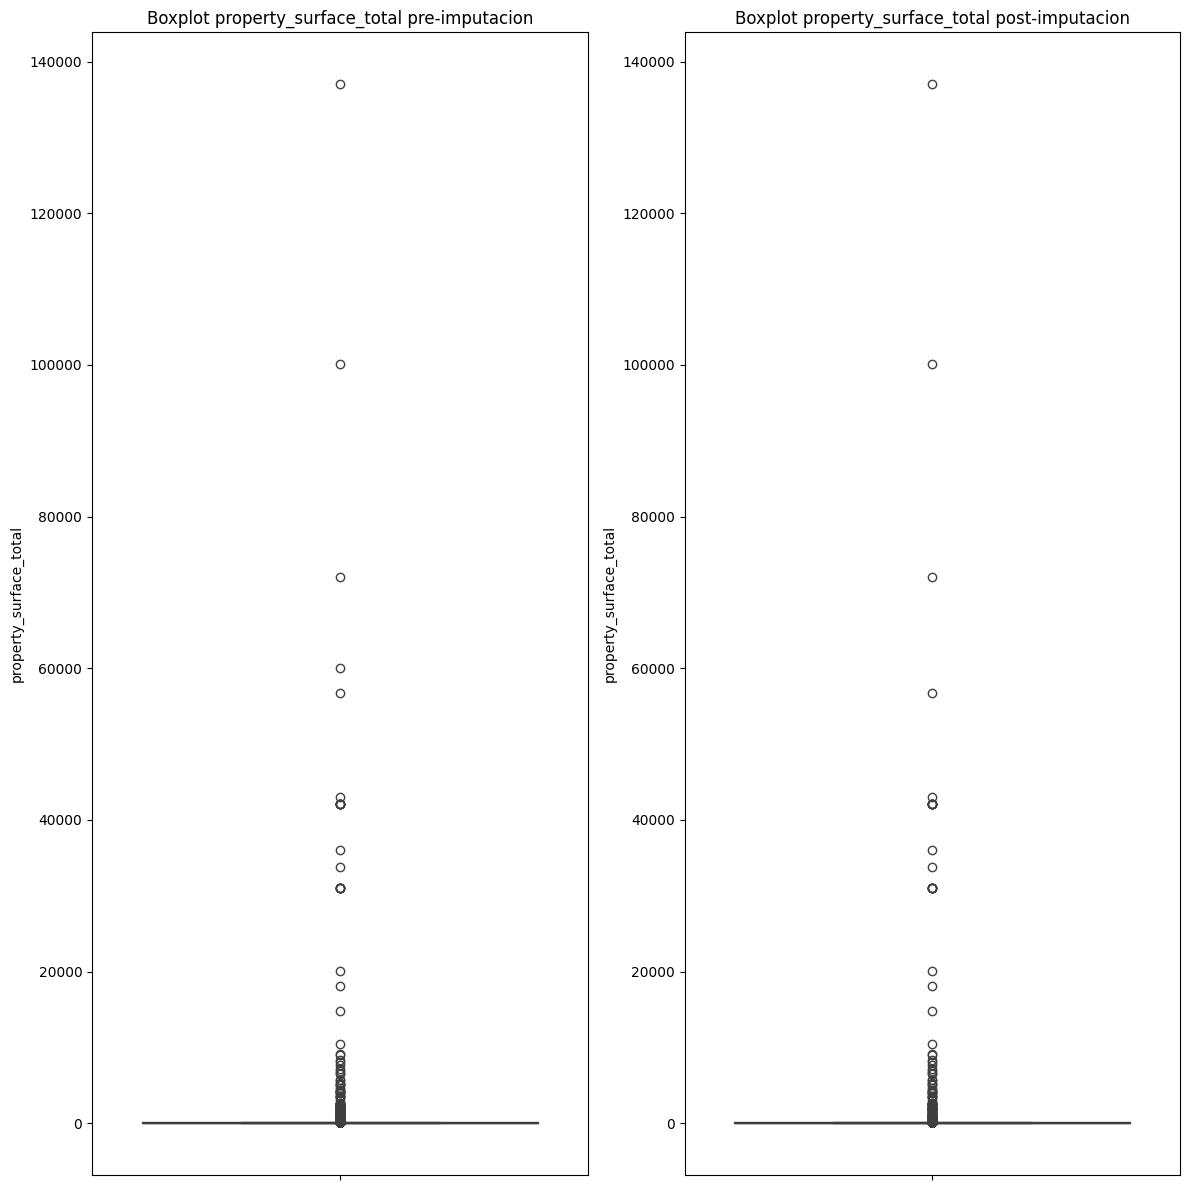

In [89]:
generar_distribucion("property_surface_total")

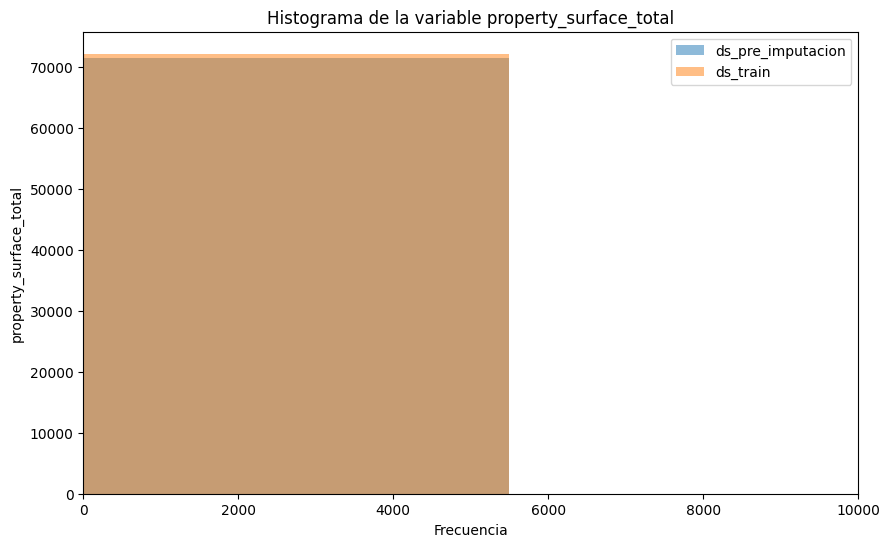

In [90]:
# Trama dos histogramas en la misma figura
plt.figure(figsize=(10, 6))

# Histograma para ds_pre_imputacion en el eje y (invertido)
plt.hist(ds_pre_imputacion['property_surface_total'], bins=25, alpha=0.5, label='ds_pre_imputacion')

# Histograma para ds_train en el eje y (invertido)
plt.hist(ds_train['property_surface_total'], bins=25, alpha=0.5, label='ds_train')

# Añadir título y etiquetas de los ejes
plt.title("Histograma de la variable property_surface_total")
plt.xlabel("Frecuencia")
plt.ylabel("property_surface_total")

plt.xlim(0, 10000)  # Límites y desde 0 hasta 15

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

Observamos una notable disparidad en la cantidad de datos faltantes antes de la imputación de la variable "superficie total".

In [91]:
pre_total = obtener_cantidad_variables(ds_pre_imputacion,'property_surface_total')
pre_total.head()

,property_surface_total,cantidad
0,50.0,1421
1,40.0,1363
2,45.0,1272
3,42.0,1241
4,60.0,1209


In [92]:
post_total = obtener_cantidad_variables(ds_train,'property_surface_total')
post_total.head()

,property_surface_total,cantidad
0,50.0,1346
1,40.0,1332
2,45.0,1228
3,42.0,1197
4,35.0,1160


In [93]:
comparar_imputacion(pre_total,post_total,'property_surface_total')

75 registros se imputaron con el valor de 50.0 property_surface_total
31 registros se imputaron con el valor de 40.0 property_surface_total
44 registros se imputaron con el valor de 45.0 property_surface_total
44 registros se imputaron con el valor de 42.0 property_surface_total
49 registros se imputaron con el valor de 60.0 property_surface_total
46 registros se imputaron con el valor de 35.0 property_surface_total
68 registros se imputaron con el valor de 38.0 property_surface_total
41 registros se imputaron con el valor de 55.0 property_surface_total
47 registros se imputaron con el valor de 37.0 property_surface_total
31 registros se imputaron con el valor de 43.0 property_surface_total
33 registros se imputaron con el valor de 44.0 property_surface_total
41 registros se imputaron con el valor de 36.0 property_surface_total
59 registros se imputaron con el valor de 34.0 property_surface_total
45 registros se imputaron con el valor de 48.0 property_surface_total
34 registros se impu

Podemos concluir que la mayoría de los valores faltantes en la variable "property_surface_total" fueron reemplazados con una superficie total de 73 m²


####Comparación property_surface_covered

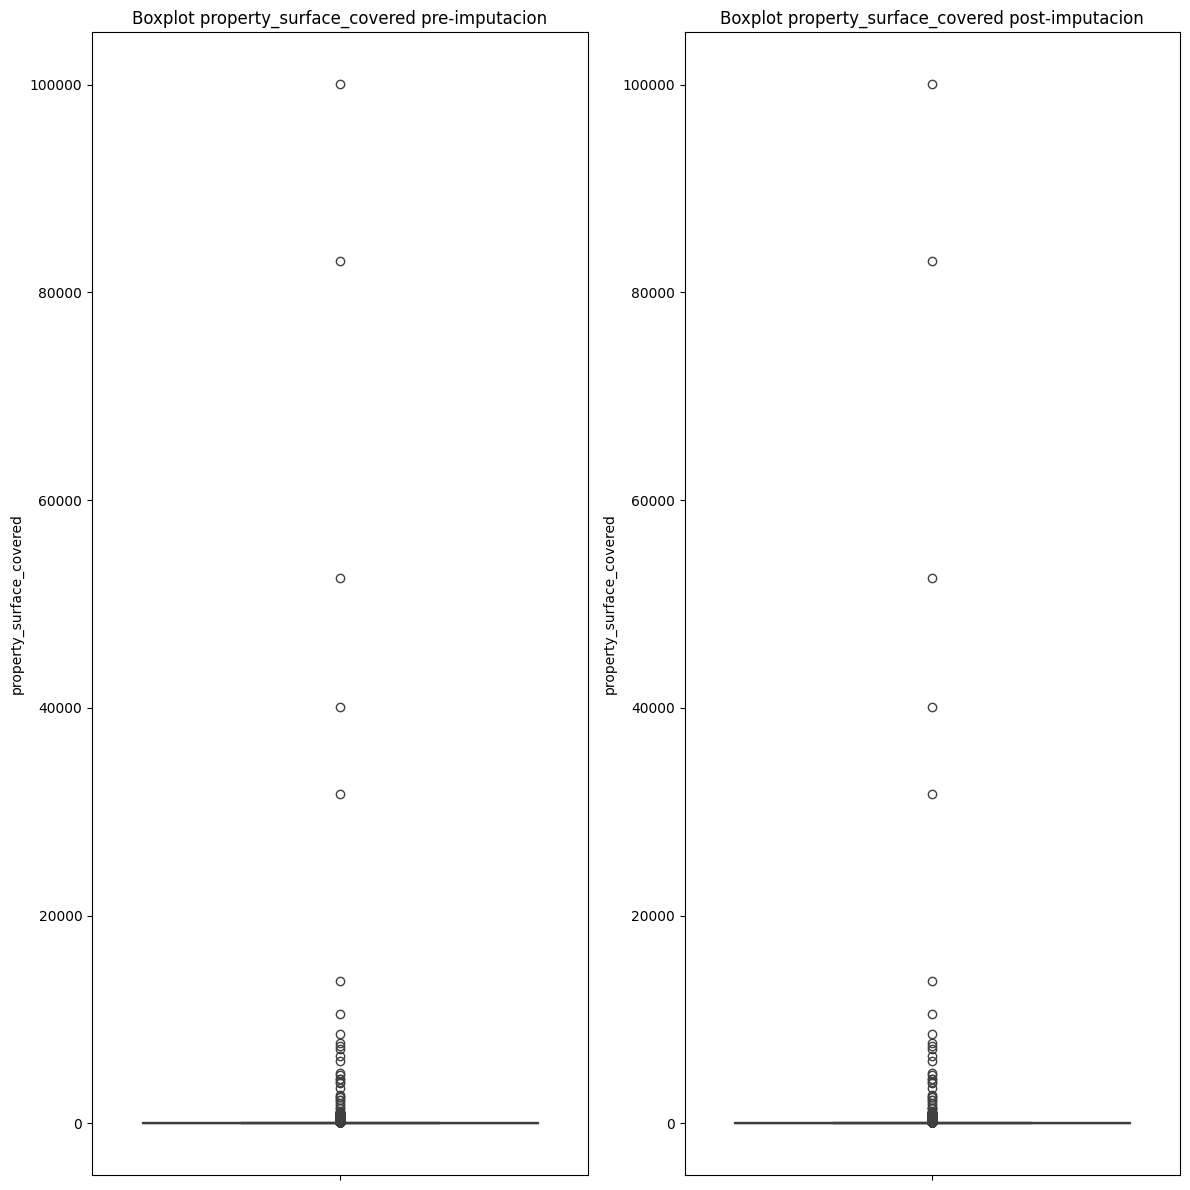

In [94]:
generar_distribucion("property_surface_covered")

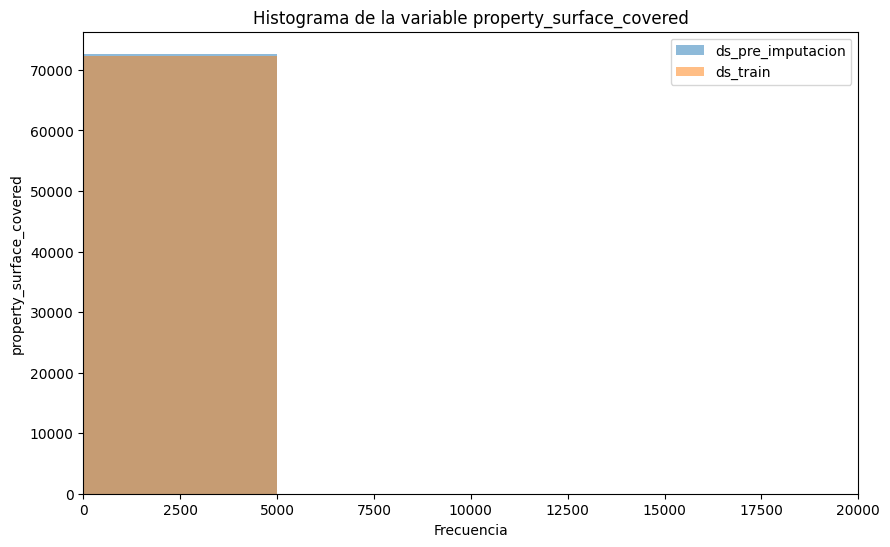

In [95]:
# Trama dos histogramas en la misma figura
plt.figure(figsize=(10, 6))

# Histograma para ds_pre_imputacion en el eje y (invertido)
plt.hist(ds_pre_imputacion['property_surface_covered'], bins=20, alpha=0.5,  label='ds_pre_imputacion')

# Histograma para ds_train en el eje y (invertido)
plt.hist(ds_train['property_surface_covered'], bins=20, alpha=0.5,  label='ds_train')

# Añadir título y etiquetas de los ejes
plt.title("Histograma de la variable property_surface_covered")
plt.xlabel("Frecuencia")
plt.ylabel("property_surface_covered")


plt.xlim(0,20000)  # Límites x desde 0 hasta 40000

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

Se observa una ligera disparidad en los datos faltantes. Se puede inferir que se imputaron pocos datos para la variable "property_surface_covered", ya que esta variable tenía entre los menos valores nulos.

In [96]:
pre_cubierto = obtener_cantidad_variables(ds_pre_imputacion,'property_surface_covered')
pre_cubierto.head()

,property_surface_covered,cantidad
0,40.0,1876
1,38.0,1621
2,50.0,1602
3,45.0,1532
4,42.0,1466


In [97]:
post_cubierto = obtener_cantidad_variables(ds_train,'property_surface_covered')
post_cubierto.head()

,property_surface_covered,cantidad
0,40.0,1822
1,50.0,1553
2,38.0,1546
3,45.0,1468
4,42.0,1419


In [98]:
comparar_imputacion(pre_cubierto,post_cubierto,'property_surface_covered')

54 registros se imputaron con el valor de 40.0 property_surface_covered
68 registros se imputaron con el valor de 38.0 property_surface_covered
56 registros se imputaron con el valor de 50.0 property_surface_covered
64 registros se imputaron con el valor de 45.0 property_surface_covered
47 registros se imputaron con el valor de 42.0 property_surface_covered
63 registros se imputaron con el valor de 35.0 property_surface_covered
51 registros se imputaron con el valor de 37.0 property_surface_covered
46 registros se imputaron con el valor de 60.0 property_surface_covered
59 registros se imputaron con el valor de 32.0 property_surface_covered
48 registros se imputaron con el valor de 30.0 property_surface_covered
43 registros se imputaron con el valor de 36.0 property_surface_covered
54 registros se imputaron con el valor de 34.0 property_surface_covered
63 registros se imputaron con el valor de 33.0 property_surface_covered
42 registros se imputaron con el valor de 43.0 property_surface_

Podemos concluir que la mayoría de los valores faltantes en la variable "property_surface_covered" fueron completados con una superficie cubierta de 78 m²

####Comparación latitud

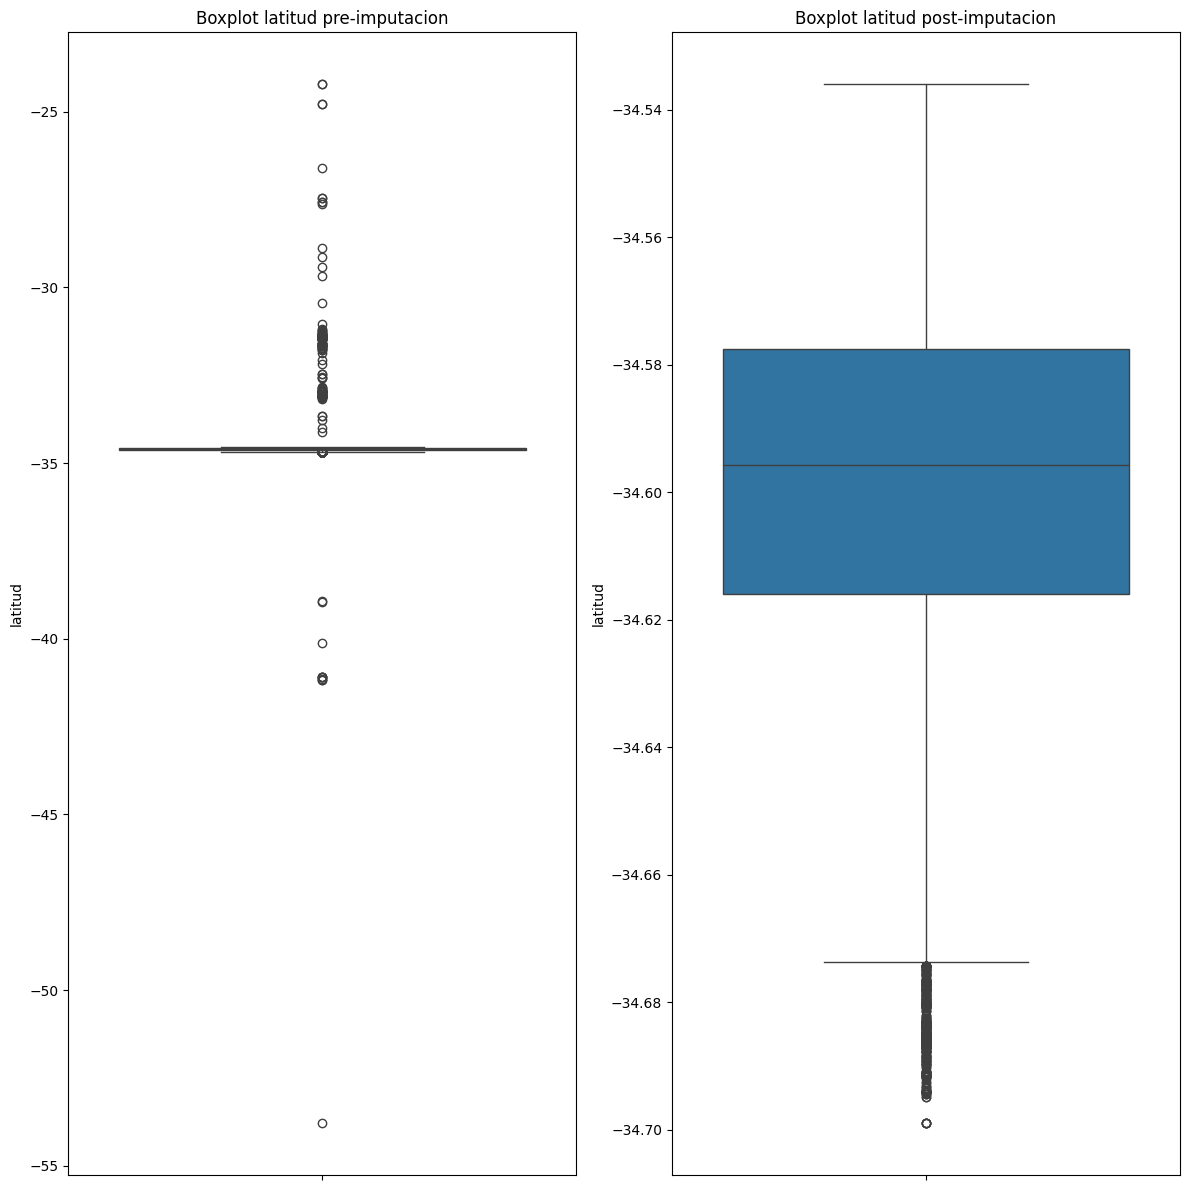

In [99]:
generar_distribucion("latitud")

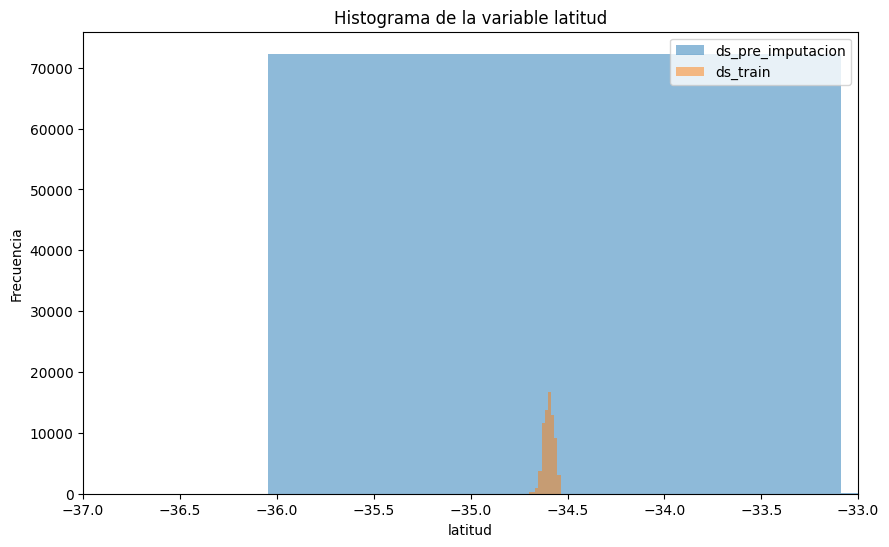

In [100]:
# Trama dos histogramas en la misma figura
plt.figure(figsize=(10, 6))

# Histograma para ds_pre_imputacion en el eje y (invertido)
plt.hist(ds_pre_imputacion['latitud'], bins=10, alpha=0.5, label='ds_pre_imputacion')

# Histograma para ds_train en el eje y (invertido)
plt.hist(ds_train['latitud'], bins=10, alpha=0.5, label='ds_train')

# Establecer los límites del eje x en el rango de -40 a -30
plt.xlim(-37, -33)

# Añadir título y etiquetas de los ejes
plt.title("Histograma de la variable latitud")
plt.xlabel("latitud")
plt.ylabel("Frecuencia")

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

Se puede observar que antes de la imputación, la latitud tenía una frecuencia constante para todos sus valores. Sin embargo, al imputar los datos, la frecuencia varía más, generando una distribución en forma de campana de Gauss. Se destaca que la latitud aproximada con la máxima cantidad de datos nulos completos es alrededor de -34.58.

In [101]:
pre_latitud = obtener_cantidad_variables(ds_pre_imputacion,'latitud')
pre_latitud

,latitud,cantidad
0,-34.541250,120
1,-34.619406,92
2,-34.604538,92
3,-34.541616,86
4,-34.582098,77
...,...,...
39256,-34.599603,1
39257,-34.600774,1
39258,-34.593211,1
39259,-34.596867,1


In [102]:
post_latitud = obtener_cantidad_variables(ds_train,'latitud')
post_latitud

,latitud,cantidad
0,-34.541250,120
1,-34.604538,92
2,-34.619406,92
3,-34.541616,86
4,-34.581910,77
...,...,...
39115,-34.568193,1
39116,-34.571572,1
39117,-34.630646,1
39118,-34.609160,1


Parecieran ser iguales... pero lo hemos imputado

In [103]:
pre_latitud.equals(post_latitud)

False

In [104]:
print(len(pre_latitud))
print(len(post_latitud))
print('diferencia: {}'.format(len(pre_latitud)-len(post_latitud)))

39261
39120
diferencia: 141


####Comparación longitud

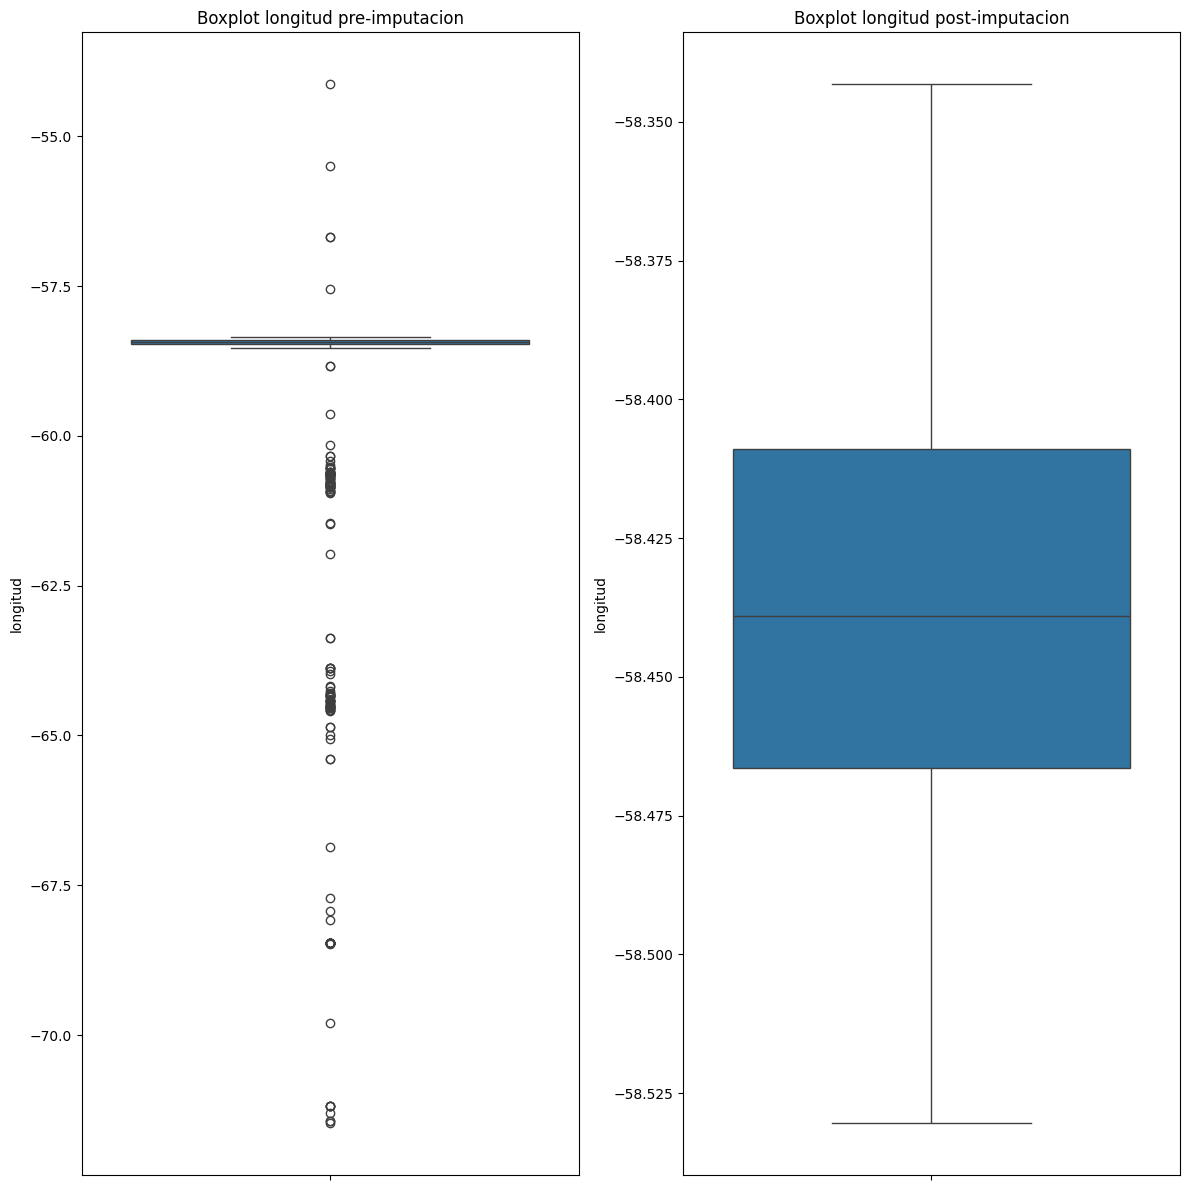

In [105]:
generar_distribucion("longitud")

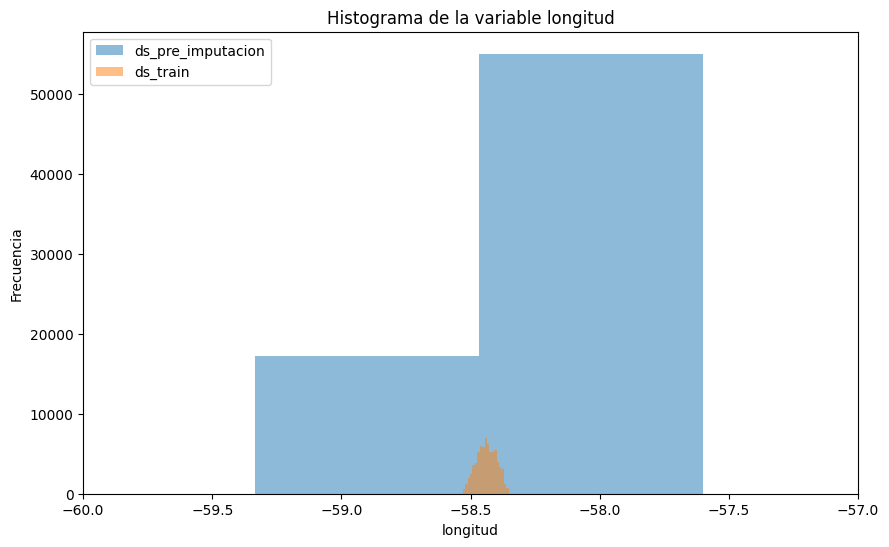

In [106]:
# Trama dos histogramas en la misma figura
plt.figure(figsize=(10, 6))

# Histograma para ds_pre_imputacion en el eje y (invertido)
plt.hist(ds_pre_imputacion['longitud'], bins=20, alpha=0.5, label='ds_pre_imputacion')

# Histograma para ds_train en el eje y (invertido)
plt.hist(ds_train['longitud'], bins=20, alpha=0.5, label='ds_train')


# Añadir título y etiquetas de los ejes
plt.title("Histograma de la variable longitud")
plt.xlabel("longitud")
plt.ylabel("Frecuencia")


# Establecer los límites del eje x en el rango de -40 a -30
plt.xlim(-60, -57)

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

Todos los valores que se mencionarán en el siguiente párrafo se consideran aproximados.

Antes de la imputación, se observa que la latitud tenía una frecuencia medianamente constante. Desde la latitud -59.5 hasta -58.5, la frecuencia es de aproximadamente 18000, luego aumenta en más de 50000 hasta llegar a la latitud -57.5.

Tras la imputación de los datos, se observa una variación en la frecuencia que genera una distribución en forma de campana de Gauss. La latitud aproximada con la máxima cantidad de datos nulos completos es alrededor de -58.400.

In [107]:
pre_longitud = obtener_cantidad_variables(ds_pre_imputacion,'longitud')
pre_longitud.head()

,longitud,cantidad
0,-58.472966,120
1,-58.451999,92
2,-58.424956,92
3,-58.473377,86
4,-58.449381,77


In [108]:
post_longitud = obtener_cantidad_variables(ds_train,'longitud')
post_longitud.head()

,longitud,cantidad
0,-58.472966,120
1,-58.424956,92
2,-58.451999,92
3,-58.473377,86
4,-58.449381,77


In [109]:
pre_longitud.equals(post_longitud)

False

In [110]:
print(len(pre_longitud))
print(len(post_longitud))
print('diferencia: {}'.format(len(pre_longitud)-len(post_longitud)))

39090
38950
diferencia: 140


####Comparación place_l3

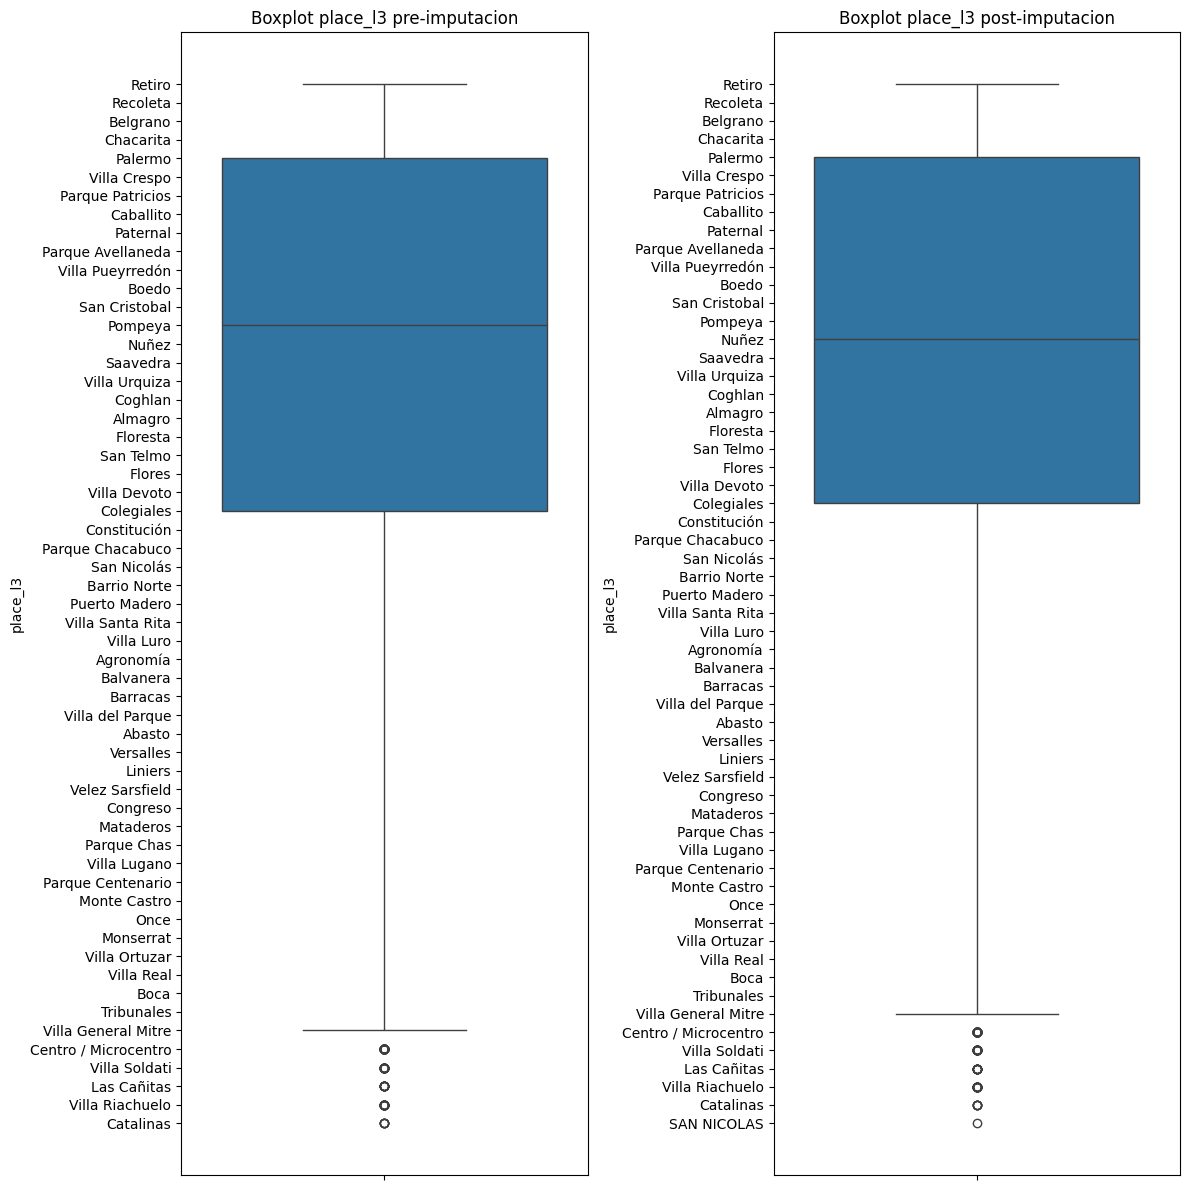

In [111]:
generar_distribucion("place_l3")

Se observa que antes de la imputación, el barrio con mayor cantidad de propiedades era San Cristóbal, mientras que después de la imputación, la media ha cambiado y ahora es Villa Urquiza. No obstante, Palermo continúa siendo el barrio con la mayor cantidad de propiedades en ambos casos.

In [112]:
pre_barrio = obtener_cantidad_variables(ds_pre_imputacion,'place_l3')
pre_barrio.head()

,place_l3,cantidad
0,Palermo,11353
1,Belgrano,7174
2,Caballito,5751
3,Recoleta,5032
4,Villa Urquiza,3770


In [113]:
post_barrio = obtener_cantidad_variables(ds_train,'place_l3')
post_barrio.head()

,place_l3,cantidad
0,Palermo,10650
1,Belgrano,6662
2,Caballito,5610
3,Recoleta,4840
4,Villa Urquiza,3649


In [114]:
comparar_imputacion(pre_barrio,post_barrio,'place_l3')

703 registros se imputaron con el valor de Palermo place_l3
512 registros se imputaron con el valor de Belgrano place_l3
141 registros se imputaron con el valor de Caballito place_l3
192 registros se imputaron con el valor de Recoleta place_l3
121 registros se imputaron con el valor de Villa Urquiza place_l3
119 registros se imputaron con el valor de Almagro place_l3
173 registros se imputaron con el valor de Nuñez place_l3
83 registros se imputaron con el valor de Villa Crespo place_l3
92 registros se imputaron con el valor de Flores place_l3
147 registros se imputaron con el valor de Barrio Norte place_l3
60 registros se imputaron con el valor de Balvanera place_l3
7 registros se imputaron con el valor de Colegiales place_l3
4 registros se imputaron con el valor de Villa Devoto place_l3
8 registros se imputaron con el valor de Saavedra place_l3
8 registros se imputaron con el valor de Villa del Parque place_l3
59 registros se imputaron con el valor de Puerto Madero place_l3
67 regist

Podemos concluir que la mayoría de los valores faltantes en la variable "place_l3" fueron completados con el nombre del barrio "Palermo".

## Valores atípicos

# Agrupamiento
En este punto se busca analizar si es posible agrupar los datos en función de algún criterio.

##Clustering
Analizar la tendencia al clustering del dataset.

In [115]:
ds_train.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
260196,Mls9WLcZ7ds/XoXLJSH0dA==,2021-04-14,2021-06-18,2021-04-14,-34.592759,-58.383464,Capital Federal,Retiro,Venta,Departamento,3.0,2.0,119.0,84.0,227000.0,USD,VENTA DEPARTAMENTO RECOLETA CON PATIO
301583,AIa+daa3G7Yb2XeBOcCfYQ==,2021-08-10,2021-12-13,2021-08-10,-34.588555,-58.387967,Capital Federal,Recoleta,Venta,Departamento,5.0,4.0,205.0,195.0,650000.0,USD,"Av. Alvear 1800, Recoleta - Piso elegante y lu..."
123449,/OMgM9cyLPXRcpCgnMyEEQ==,2021-08-04,9999-12-31,2021-08-04,-34.558849,-58.458606,Capital Federal,Belgrano,Venta,Departamento,3.0,2.0,77.0,77.0,200000.0,USD,3 ambientes con seguridad 24 hrs en el corazon...
391294,TOMQH5yZOvskYBUPJi1jbg==,2021-04-12,2021-04-30,2021-04-12,-34.581521,-58.449339,Capital Federal,Chacarita,Venta,Departamento,3.0,2.0,73.0,61.0,225000.0,USD,Venta Departamento 3 Amb. c/COCHERA
56136,nNAnxWblpISvRrMkFBg57g==,2021-04-09,2021-04-27,2021-04-09,-34.566708,-58.434404,Capital Federal,Palermo,Venta,Departamento,5.0,3.0,170.0,155.0,720000.0,USD,Las Cañitas SEMIPISO ESPECTACULAR 170 m2


Para agrupar, podemos dejar de lado las columnas 'place_l2' y 'place_l3', ya que podemos completar los datos necesarios para realizar el clustering utilizando las columnas de latitud y longitud. Del mismo modo, podemos descartar la información sobre el tipo de operación, título y tipo de moneda, ya que todas las propiedades son para venta, con el título de la propiedad y la moneda en dólares. Además, podemos eliminar la columna 'id', ya que generalmente solo sirve como un identificador único para cada fila y no es una característica relevante para el clustering. Similarmente, podemos descartar cualquier información relacionada con fechas, ya que no es necesaria para nuestro análisis de clustering.

In [116]:
ds_cluster_train = ds_train.copy()
ds_cluster_test = ds_test.copy()

columnas_a_eliminar = ['place_l2','place_l3','operation','property_currency','property_title','id','start_date','end_date','created_on']
ds_cluster_train.drop(columns = columnas_a_eliminar,inplace=True)
ds_cluster_test.drop(columns = columnas_a_eliminar,inplace=True)

In [117]:
ds_cluster_train.head()

,latitud,longitud,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
260196,-34.592759,-58.383464,Departamento,3.0,2.0,119.0,84.0,227000.0
301583,-34.588555,-58.387967,Departamento,5.0,4.0,205.0,195.0,650000.0
123449,-34.558849,-58.458606,Departamento,3.0,2.0,77.0,77.0,200000.0
391294,-34.581521,-58.449339,Departamento,3.0,2.0,73.0,61.0,225000.0
56136,-34.566708,-58.434404,Departamento,5.0,3.0,170.0,155.0,720000.0


In [118]:
ds_cluster_test.head()

,latitud,longitud,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
240363,-34.613468,-58.369054,Departamento,4.0,3.0,96.0,96.0,160000.0
140941,-34.567318,-58.476828,PH,3.0,2.0,108.0,88.0,143000.0
223108,-34.573707,-58.489148,Departamento,1.0,NaN,97.0,35.0,129000.0
61120,-34.553400,-58.485339,PH,5.0,NaN,110.0,87.0,135000.0
339330,-34.623129,-58.426565,Departamento,2.0,1.0,49.0,41.0,125000.0


Vamos a realizar una transformación de variables para trabajar con todos datos numéricos. En este caso, vamos a utilizar la regresión logística para la variable proterty_type

In [119]:
ds_cluster_train = pd.get_dummies(ds_cluster_train, columns=["property_type"])
ds_cluster_train.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_type_Casa,property_type_Departamento,property_type_PH
260196,-34.592759,-58.383464,3.0,2.0,119.0,84.0,227000.0,0,1,0
301583,-34.588555,-58.387967,5.0,4.0,205.0,195.0,650000.0,0,1,0
123449,-34.558849,-58.458606,3.0,2.0,77.0,77.0,200000.0,0,1,0
391294,-34.581521,-58.449339,3.0,2.0,73.0,61.0,225000.0,0,1,0
56136,-34.566708,-58.434404,5.0,3.0,170.0,155.0,720000.0,0,1,0


In [120]:
ds_cluster_test = pd.get_dummies(ds_cluster_test, columns=["property_type"])
ds_cluster_test.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_type_Casa,property_type_Departamento,property_type_PH
240363,-34.613468,-58.369054,4.0,3.0,96.0,96.0,160000.0,0,1,0
140941,-34.567318,-58.476828,3.0,2.0,108.0,88.0,143000.0,0,0,1
223108,-34.573707,-58.489148,1.0,NaN,97.0,35.0,129000.0,0,1,0
61120,-34.553400,-58.485339,5.0,NaN,110.0,87.0,135000.0,0,0,1
339330,-34.623129,-58.426565,2.0,1.0,49.0,41.0,125000.0,0,1,0


Aplico máximos y minimos para el dataset

In [121]:
def aplicar_max_min(ds, columnas):
    scaler = MinMaxScaler()
    for columna in columnas:
        ds[[columna]] = scaler.fit_transform(ds[[columna]])

aplicar_max_min(ds_cluster_train,columnas_con_numeros)

##Grupos
Estimar la cantidad apropiada de grupos que se deben formar.

Para ello vamos a utilizar la Regla del codo (Elbow Method).

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

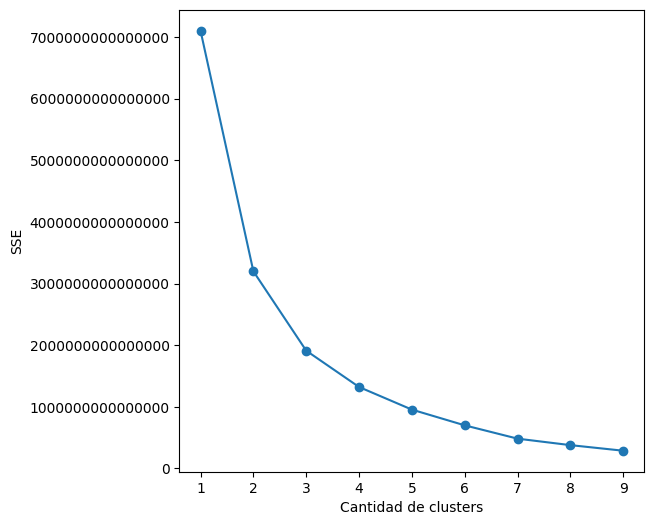

In [127]:
# Corro el algoritmo con K entre 2 y 10 y voy guardando el error para luego graficarlo.
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(ds_cluster_train)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')

# Desactivar la notación científica en el eje y
plt.ticklabel_format(style='plain', axis='y')

plt.show()

Al ver el gráfico no tenemos un codo pronunciadamente. Entonces verificamos la cantidad de conjuntos a elegir con el método de Silhouette.

##Grupos con Silhouette <font color='red'> REVISAR </font>
Evaluar la calidad de los grupos formados realizando un análisis de Silhouette

In [131]:
list_k = list(range(2, 6))

for n_clusters in list_k:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(ds_cluster_train)

    score = silhouette_score (ds_cluster_train, preds)
    print ("\n\nFor n_clusters =" + str(n_clusters) + " silhouette score is " + str(score))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(




For n_clusters =2 silhouette score is 0.8915255412999158


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(




For n_clusters =3 silhouette score is 0.7818553578450381


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(




For n_clusters =4 silhouette score is 0.7191580976224482


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(




For n_clusters =5 silhouette score is 0.7050874481582098


##Análisis de grupo
Realizar un análisis de cada grupo intentando entender en función de qué características
fueron formados.

##Mapa de CABA
Graficar sobre un mapa de CABA los avisos coloreados según el grupo al que pertenecen.

##Análisis con tres grupos
Repetir el análisis anterior, utilizando sólo 3 grupos.